In [1]:
# import datetime
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web


#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }
inflation_target = .02
unemployment_target = .04
# Select start and end dates
start = datetime.datetime(2001, 12, 1)
end = datetime.datetime.today()
annual_div = {"Q":4,
             "W":52,
             "M":12}
last_month = 1
next_month = -1
next_year = -12
# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
if "data_gathered" not in locals():
    freq = "M"
    year = annual_div[freq]
    data = gather_data(data_codes, start, 
          end = end, freq = freq)
    data.fillna(0, inplace=True)
    for key in data.keys():
        data["Log " + key]= np.log(data[key])
    # Create new variables
    data_gathered = True

ticker = "^GSPC"
data["Base: Currency in Circulation ($ Mil)"] = data["Base: Currency in Circulation ($ Bil)"].mul(1000)
data["Base: Currency not in Circulation ($ Mil)"] = data["Base: Total ($ Mil)"].sub(data["Base: Currency in Circulation ($ Mil)"])
data["Currency in Circulation Growth Rate (%)"] = data["Base: Currency in Circulation ($ Mil)"].pct_change(year) * 100
data["Currency in Circulation Growth Rate Diff (%)"] =  data["Currency in Circulation Growth Rate (%)"].diff(year)
data["Currency in Circulation Growth Rate Diff-in-Diff (%)"] =  data["Currency in Circulation Growth Rate Diff (%)"].diff(year)

data["% Currency not in Circulation"] = data["Base: Currency not in Circulation ($ Mil)"].div(data["Base: Total ($ Mil)"]) * 100
data["% Currency in Circulation"] = data["Base: Currency in Circulation ($ Mil)"].div(data["Base: Total ($ Mil)"]) * 100
data["Base: Total Growth Rate (%)"] = data["Base: Total ($ Mil)"]
data["Change % Currency not in Circulation"] = data["% Currency not in Circulation"].diff(year)    
data["Currency not in Circulation Growth Rate (%)"] = data["Base: Currency not in Circulation ($ Mil)"].pct_change(year) * 100    
data["Inflation (CPI)"] =  web.DataReader("CPIAUCSL", "fred", start, end).resample(freq).mean().pct_change(year).mul(100).shift(last_month).dropna()
data["Inflation (PCE)"] = web.DataReader("PCEPILFE", "fred", start, end).resample(freq).mean().pct_change(year).shift(last_month).mul(100).dropna()

data["Effective Federal Funds Rate Diff (%)"] = data["Effective Federal Funds Rate (%)"].diff(year)
data["Effective Federal Funds Rate Diff-in-Diff (%)"] = data["Effective Federal Funds Rate Diff (%)"].diff(year)
data["1 Year Treasury Rate (%; diff)"] = data["1 Year Treasury Rate (%)"].diff(year)
data["2 Year Treasury Rate (%; diff)"] = data["2 Year Treasury Rate (%)"].diff(year)
data["10 Year Treasury Rate (%; diff)"] = data["10 Year Treasury Rate (%)"].diff(year)
data["30 Year Treasury Rate (%; diff)"] = data["30 Year Treasury Rate (%)"].diff(year)
data["Unemployment Rate Diff"] = data["Unemployment Rate"].diff(year)
data["Unemployment Rate Diff-in-Diff"] = data["Unemployment Rate Diff"].diff(year)
data["Nominal GDP ($ Mil)"] = data["Nominal GDP ($ Bil)"].mul(1000)
data["Nominal GDP Growth Rate (%)"] = data["Nominal GDP ($ Bil)"].pct_change(year) * 100
data["Real GDP ($ Mil)"] = data["Real GDP ($ Bil)"].mul(1000)
data["Real GDP Growth Rate (%)"] = data["Real GDP ($ Bil)"].pct_change(year) * 100
data["Inflation (GDPDEF)"] = data["GDP Deflator"].pct_change(year) * 100
data["Real Currency in Circulation Growth Rate (%)"] = data["Currency in Circulation Growth Rate (%)"].sub(data["Inflation (GDPDEF)"])
data["Currency in Circulation Velocity"] = data["Nominal GDP ($ Mil)"].div(data["Base: Currency in Circulation ($ Mil)"])
data["Currency in Circulation % Change Velocity"] = data["Currency in Circulation Velocity"].pct_change(year)

data["Inflation Loss"]= data["Inflation (PCE)"].sub(inflation_target)
data["Unemployment Loss"]= data["Unemployment Rate"].sub(unemployment_target)
data["Inflation Loss Sq"]= data["Inflation (PCE)"].sub(inflation_target).pow(2)
data["Inflation Loss Sq"][data["Inflation Loss"] < 0] = data["Inflation Loss Sq"].mul(-1)

data["Unemployment Loss Sq"]= data["Unemployment Rate"].sub(unemployment_target).pow(2)
data["Unemployment Loss Sq"][data["Unemployment Loss"] < 0] = data["Unemployment Loss Sq"].mul(-1)



data["Inflation Loss Diff"]= data["Inflation Loss"].diff(year)
data["Unemployment Loss Diff"]= data["Unemployment Loss"].diff(year)
data["Inflation Loss Sq Diff"]= data["Inflation Loss Sq"].diff(year)
data["Unemployment Loss Sq Diff"]= data["Unemployment Loss Sq"].diff(year)

data["Inflation Loss Diff-in-Diff"]= data["Inflation Loss Diff"].diff(year)
data["Unemployment Loss Diff-in-Diff"]= data["Unemployment Loss Diff"].diff(year)
data["Inflation Loss Sq Diff-in-Diff"]= data["Inflation Loss Sq Diff"].diff(year)
data["Unemployment Loss Sq Diff-in-Diff"]= data["Unemployment Loss Sq Diff"].diff(year)


data["Linear Loss"] = data["Inflation Loss"].sub(data["Unemployment Loss"])
data["Loss Function"] = data["Inflation Loss Sq"].sub(data["Unemployment Loss Sq"])
data["Linear Loss Diff"] = data["Linear Loss"].diff(year)
data["Loss Function Diff"] = data["Loss Function"].diff(year)
data["Linear Loss Diff-in-Diff"] = data["Linear Loss Diff"].diff(year)
data["Loss Function Diff-in-Diff"] = data["Loss Function Diff"].diff(year)

data["Real 1 Year Treasury Rate"] = data["1 Year Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real 3 Month Treasury Rate"] = data["3 Month Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real 1 Month Treasury Rate"] = data["1 Month Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real Effective Federal Funds Rate"] = data['Effective Federal Funds Rate (%)'].sub(data["Inflation (CPI)"])

data["30 Year Minus 1 Year (%)"] = data["30 Year Treasury Rate (%)"].sub(data["1 Year Treasury Rate (%)"])
data["30 Year Minus 3 Month (%)"] = data["30 Year Treasury Rate (%)"].sub(data["3 Month Treasury Rate (%)"])
data["30 Year Minus 1 Month (%)"] = data["30 Year Treasury Rate (%)"].sub(data["1 Month Treasury Rate (%)"])
data["30 Year Minus Effective Federal Funds Rate"] = data["30 Year Treasury Rate (%)"].sub(data['Effective Federal Funds Rate (%)'])
data["10 Year Minus 2 Year (%)"] = data["10 Year Treasury Rate (%)"].sub(data["2 Year Treasury Rate (%)"])
data["10 Year Minus 1 Year (%)"] = data["10 Year Treasury Rate (%)"].sub(data["1 Year Treasury Rate (%)"])
data["10 Year Minus 3 Month (%)"] = data["10 Year Treasury Rate (%)"].sub(data["3 Month Treasury Rate (%)"])
data["10 Year Minus 1 Month (%)"] = data["10 Year Treasury Rate (%)"].sub(data["1 Month Treasury Rate (%)"])
data["10 Year Minus Effective Federal Funds Rate"] = data["10 Year Treasury Rate (%)"].sub(data['Effective Federal Funds Rate (%)'])

keys = list(data.keys())
keys = ["Date"] + keys
data["Date"] = data.index.astype(str)



C:\Users\JLCat\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [2]:
# import pandas_datareader.data as web
# start = datetime.datetime(2001, 12, 1)
# end = datetime.datetime.today()
# x =  web.DataReader("CPIAUCSL", "fred", start, end).resample(freq).mean().pct_change(year).mul(100).dropna()
# x

In [3]:
import yfinance as yfin
yfin.pdr_override()
data["S&P"]= web.get_data_yahoo(ticker, start = start, end = end).resample(freq).mean()["Close"].iloc[:-2]
data["S&P Growth Rate (%)"] = data["S&P"].pct_change(year)
data["S&P Growth Rate Change Diff (%)"] = data["S&P Growth Rate (%)"].diff(year)
data["Real S&P Growth Rate (%)"] = data["S&P Growth Rate (%)"].sub(data["Inflation (CPI)"])
data["VIX Diff"] = data["VIX"].diff(year)
data

[*********************100%***********************]  1 of 1 completed


,Balance Sheet: Total Assets ($ Mil),"Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)",Balance Sheet: Securities Held Outright ($ Mil),Balance Sheet: U.S. Treasuries Held Outright ($ Mil),Balance Sheet: Federal Agency Debt Securities ($ Mil),Balance Sheet: Mortgage-Backed Securities ($ Mil),Balance Sheet: Repos ($ Mil),Balance Sheet: Central Bank Liquidity Swaps ($ Mil),Balance Sheet: Direct Lending ($ Mil),Balance Sheet: Unamortized Security Premiums ($ Mil),...,10 Year Minus 1 Year (%),10 Year Minus 3 Month (%),10 Year Minus 1 Month (%),10 Year Minus Effective Federal Funds Rate,Date,S&P,S&P Growth Rate (%),S&P Growth Rate Change Diff (%),Real S&P Growth Rate (%),VIX Diff
DATE,,,,,,,,,,,,,,,,,,,,,
2002-12-31,725800.50,672844.50,629409.50,629399.50,10.0,0.00,33625.00,0.0,52.00,10811.00,...,2.582381,2.821429,2.834762,2.793994,2002-12-31,899.178574,NaN,NaN,NaN,NaN
2003-01-31,724718.40,671196.20,629416.00,629406.00,10.0,0.00,32100.00,0.0,19.40,10688.00,...,2.684286,2.859524,2.878095,2.813410,2003-01-31,895.836190,NaN,NaN,NaN,NaN
2003-02-28,721326.00,668666.25,631911.75,631901.75,10.0,0.00,27185.50,0.0,10.50,10571.25,...,2.606316,2.717368,2.707368,2.640489,2003-02-28,837.618951,NaN,NaN,NaN,NaN
2003-03-31,723651.25,672446.00,639168.25,639158.25,10.0,0.00,23625.00,0.0,11.00,10619.25,...,2.567143,2.656190,2.630952,2.554240,2003-03-31,846.621425,NaN,NaN,NaN,NaN
2003-04-30,736926.40,685518.60,645508.60,645498.60,10.0,0.00,30350.20,0.0,31.80,10574.40,...,2.691429,2.806190,2.800476,2.700571,2003-04-30,890.025713,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,7866893.25,7709974.25,7291913.75,5063447.75,2347.0,2226119.00,11.75,642.5,81423.00,349622.50,...,1.570500,1.603000,1.613500,1.562935,2021-05-31,4167.849536,0.427537,0.404802,-3.725598,-11.136500
2021-06-30,8026555.20,7874851.20,7450341.40,5149903.00,2347.0,2298091.20,0.00,516.0,87694.60,350797.60,...,1.452273,1.483182,1.491818,1.441091,2021-06-30,4238.489546,0.365202,0.290987,-4.561305,-14.162727
2021-07-31,8190356.75,8042917.00,7617340.75,5232755.50,2347.0,2382238.75,0.00,487.0,87349.25,352744.75,...,1.242857,1.266190,1.269048,1.220507,2021-07-31,4363.712798,0.360421,0.289828,-4.964087,-9.237121


In [4]:
#fedProject
# . . . 
data["Balance Sheet: Direct Lending and Central Bank Liquidity Swaps"] =\
    data["Balance Sheet: Central Bank Liquidity Swaps ($ Mil)"].add(
    data["Balance Sheet: Direct Lending ($ Mil)"])
data["Balance Sheet: Other Securities"] = data["Balance Sheet: Securities Held Outright ($ Mil)"].sub(
    data["Balance Sheet: U.S. Treasuries Held Outright ($ Mil)"]).sub(
    data["Balance Sheet: Mortgage-Backed Securities ($ Mil)"])
data["Balance Sheet: Other Assets"] = data["Balance Sheet: Total Assets ($ Mil)"].sub(
    data["Balance Sheet: Securities Held Outright ($ Mil)"]).sub(
    data["Balance Sheet: Direct Lending and Central Bank Liquidity Swaps"]).sub(
    data["Balance Sheet: Repos ($ Mil)"]).sub(
    data["Balance Sheet: Unamortized Security Premiums ($ Mil)"])
data["Balance Sheet: Other Deposits ($ Mil)"] = data["Balance Sheet: All Deposits ($ Mil)"].sub(
    data["Balance Sheet: U.S. Treasury General Account ($ Mil)"]).sub(
    data["Balance Sheet: Deposits from Dep. Institutions ($ Mil)"])
data["Balance Sheet: Other Liabilities"]= data["Balance Sheet: Total Liabilities ($ Mil)"].sub(
    data["Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)"]).sub(
    data["Balance Sheet: U.S. Treasury General Account ($ Mil)"]).sub(
    data["Balance Sheet: Deposits from Dep. Institutions ($ Mil)"]).sub(
    data["Balance Sheet: Other Deposits ($ Mil)"]).sub(
    data["Balance Sheet: Reverse Repos ($ Mil)"])


<ipython-input-5-ab5c1d4011df>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(round(y,2))+ "%" for y in y_vals])


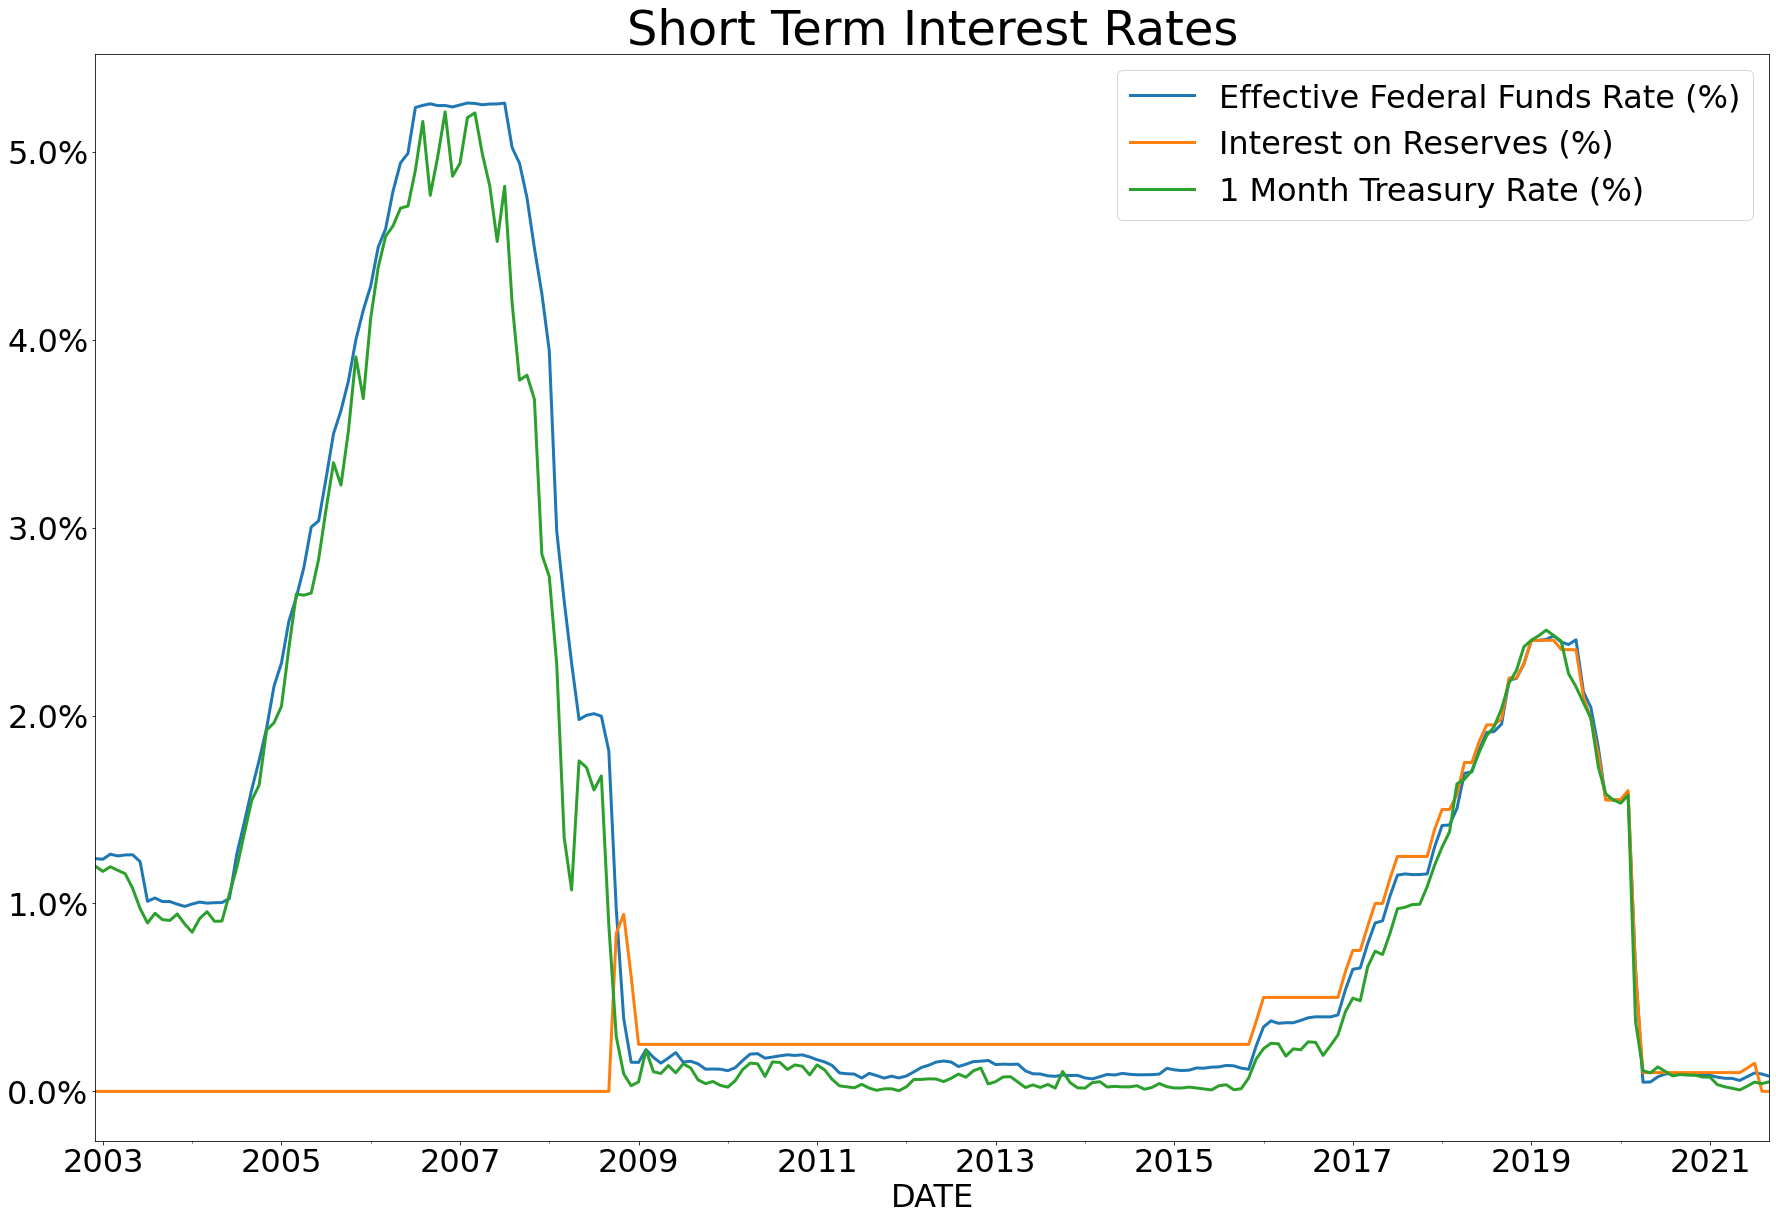

In [5]:
plt.rcParams.update({"font.size":32})
interest_vars = ["Effective Federal Funds Rate (%)",
                   "Interest on Reserves (%)",
                   "1 Month Treasury Rate (%)"]
fig, ax = plt.subplots(figsize = (30,20))
data[interest_vars].plot.line(legend=True, linewidth = 3, ax = ax)
y_vals = ax.get_yticks()
ax.set_yticklabels([str(round(y,2))+ "%" for y in y_vals])  
ax.set_title("Short Term Interest Rates", fontsize = 48)
data[["Date"] + interest_vars].to_json("shortTermRates.json", orient="records")

In [6]:
data = data.rename(columns = {
    key: key.replace("Balance Sheet: ", "").replace(" ($ Mil)", "").replace("Base: ","") for key in data.keys()})
keys = list(data.keys())
interest_rates = ["Effective Federal Funds Rate (%)",
                   "Interest on Reserves (%)",
                   "1 Month Treasury Rate (%)"]
plot_data = data.copy()
for key, val in data.items():
    if key not in interest_rates:
        try:
            plot_data[key] = val.div(10**6)
        except:
            continue

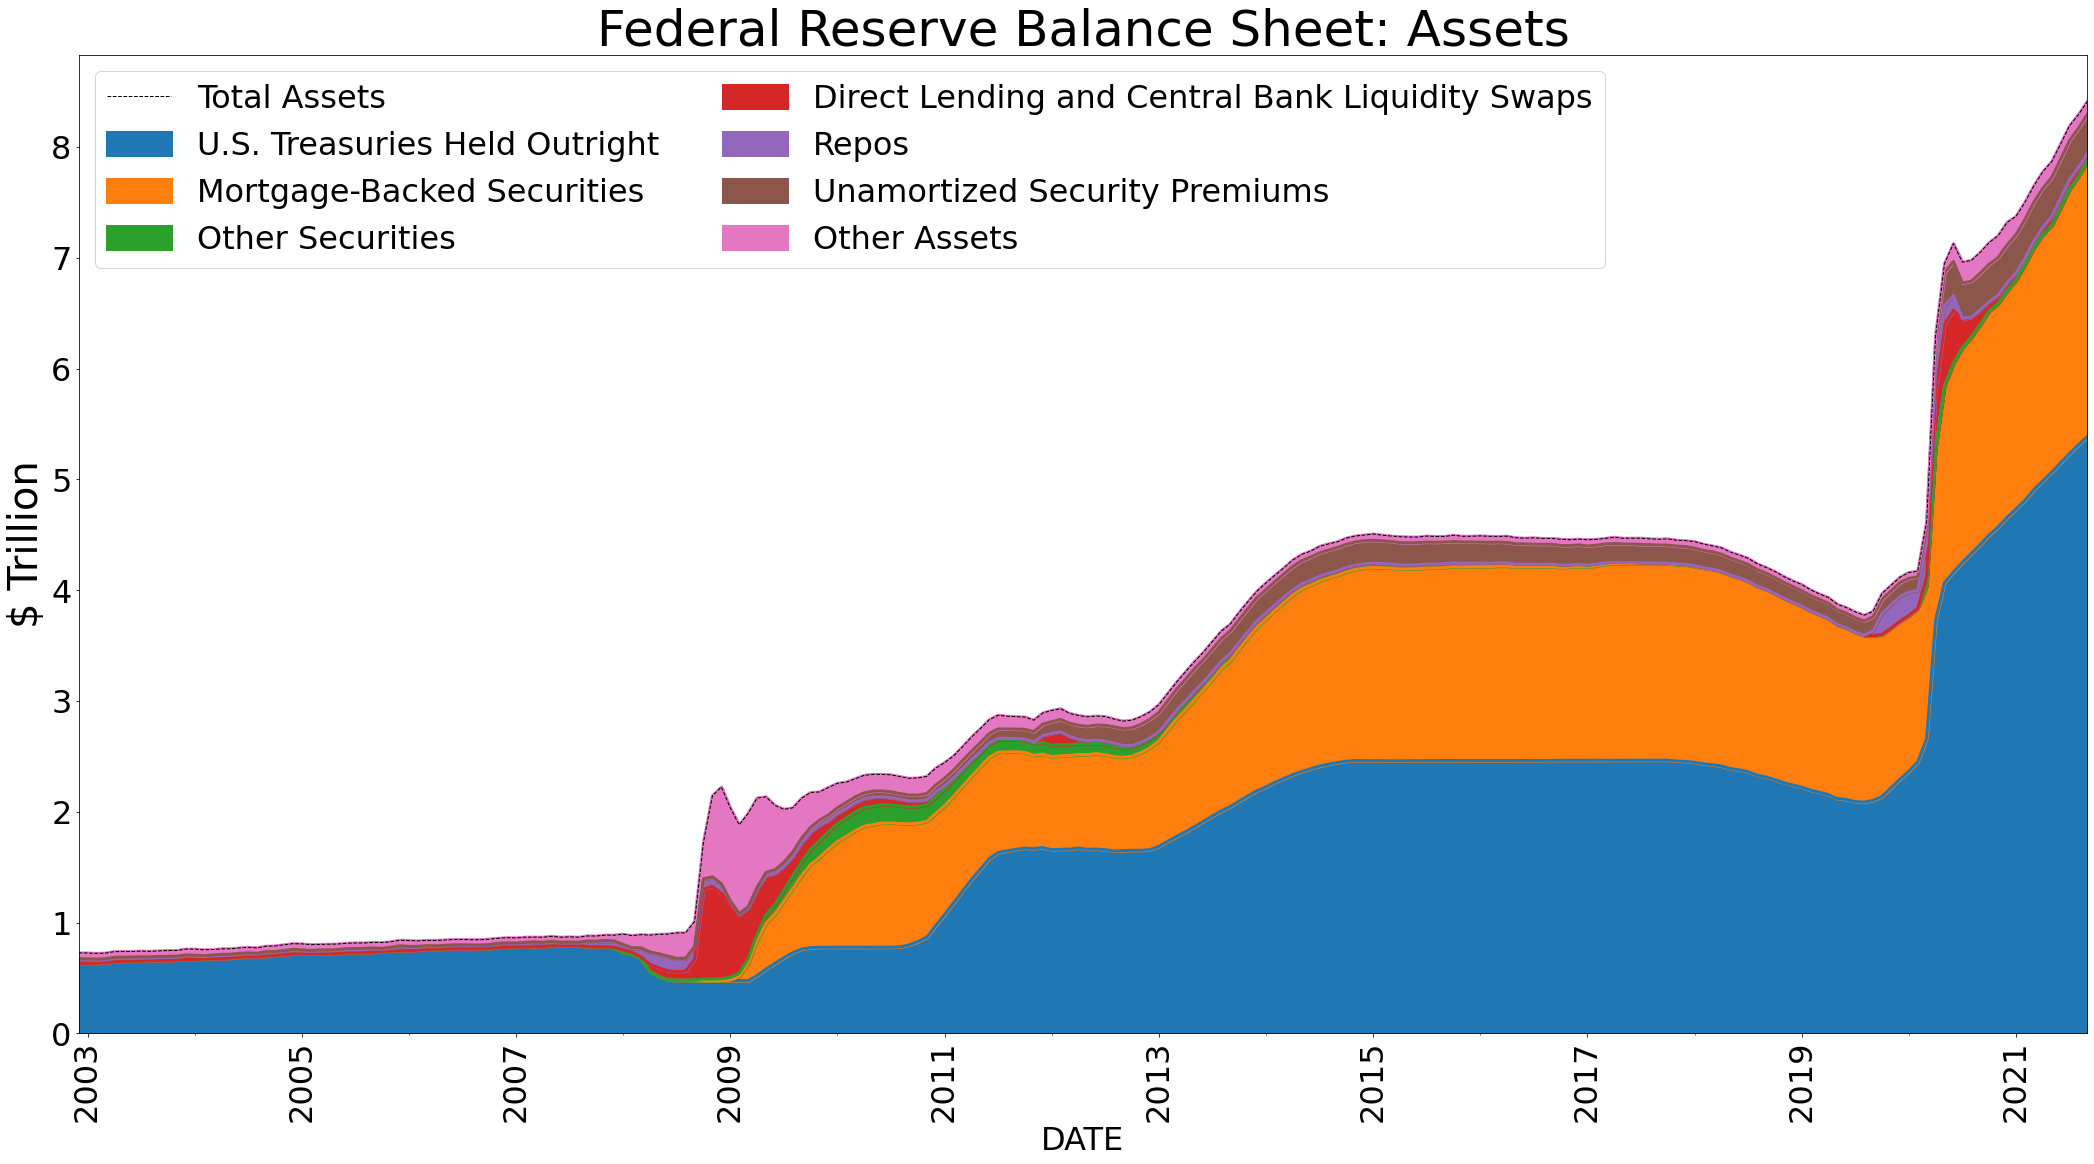

In [7]:
account_vars = ["U.S. Treasuries Held Outright",
               "Mortgage-Backed Securities",
               "Other Securities",
               "Direct Lending and Central Bank Liquidity Swaps",
               "Repos",
               "Unamortized Security Premiums",
               "Other Assets"]
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
plot_data[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
# change y vals from mil to tril
total_var = "Total Assets"
plot_data[total_var].plot.line(linewidth = 1, 
                             ax = ax, c = "k",
                             label = total_var, ls = "--")
plt.xticks(rotation = 90)
ax.legend(loc=2, ncol = 2)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Balance Sheet: Assets", fontsize = 50)
plot_data[[total_var] + account_vars].to_csv("FederalReserveAssets.csv")
plot_data[["Date"] + account_vars].to_json("fedAssets.json", orient = "records")

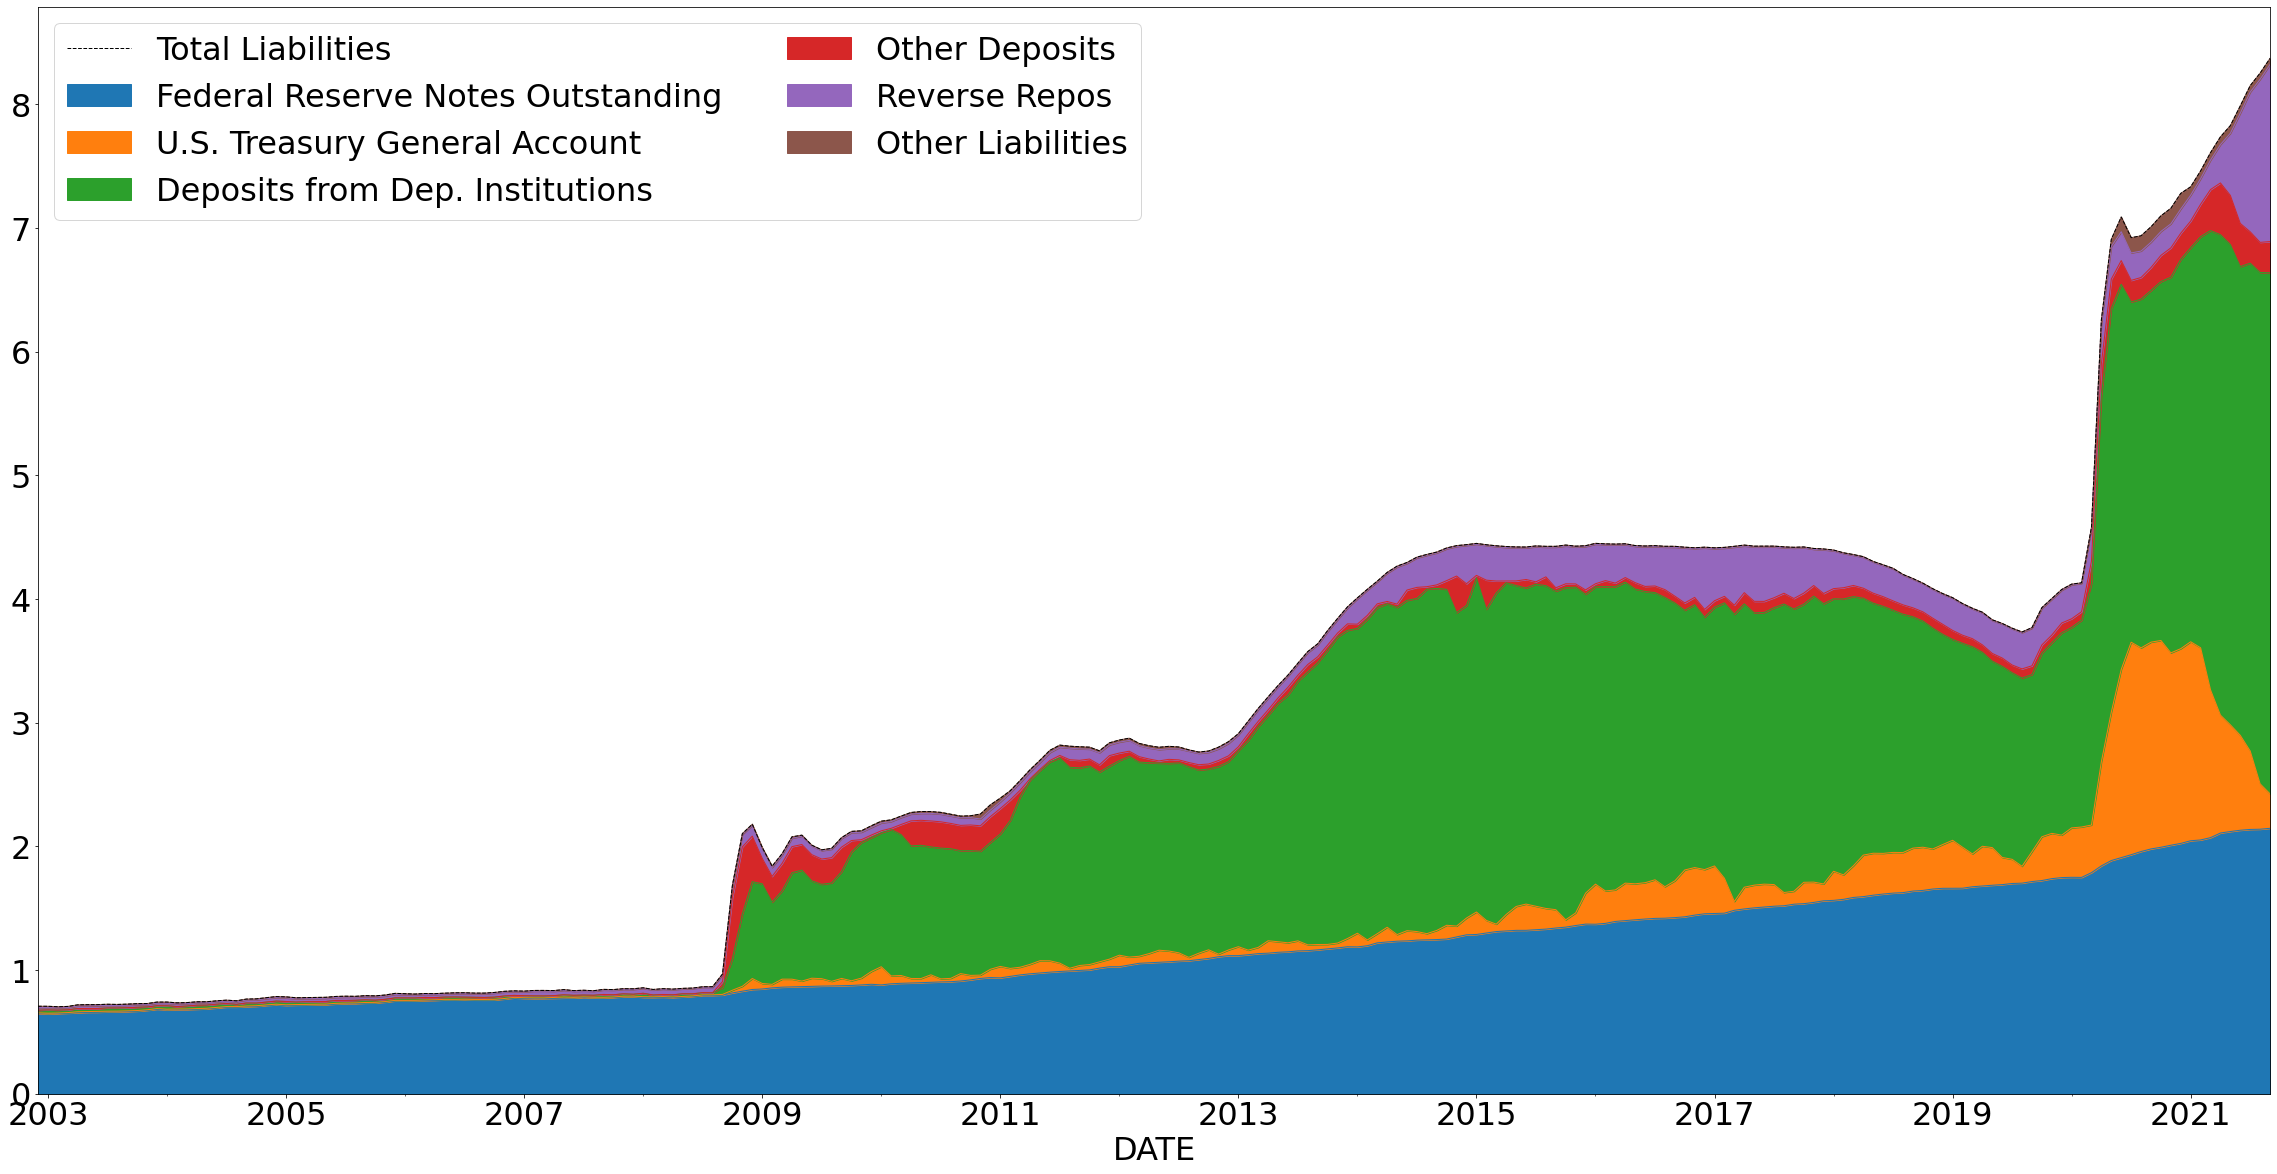

In [8]:
account_vars = ["Federal Reserve Notes Outstanding",
                "U.S. Treasury General Account",
                "Deposits from Dep. Institutions",
                "Other Deposits",
                "Reverse Repos",
                "Other Liabilities"]
total_var = "Total Liabilities"

plot_stacked_lines(
    plot_data,
    account_vars, linewidth = 1,
    total_var = "Total Liabilities")


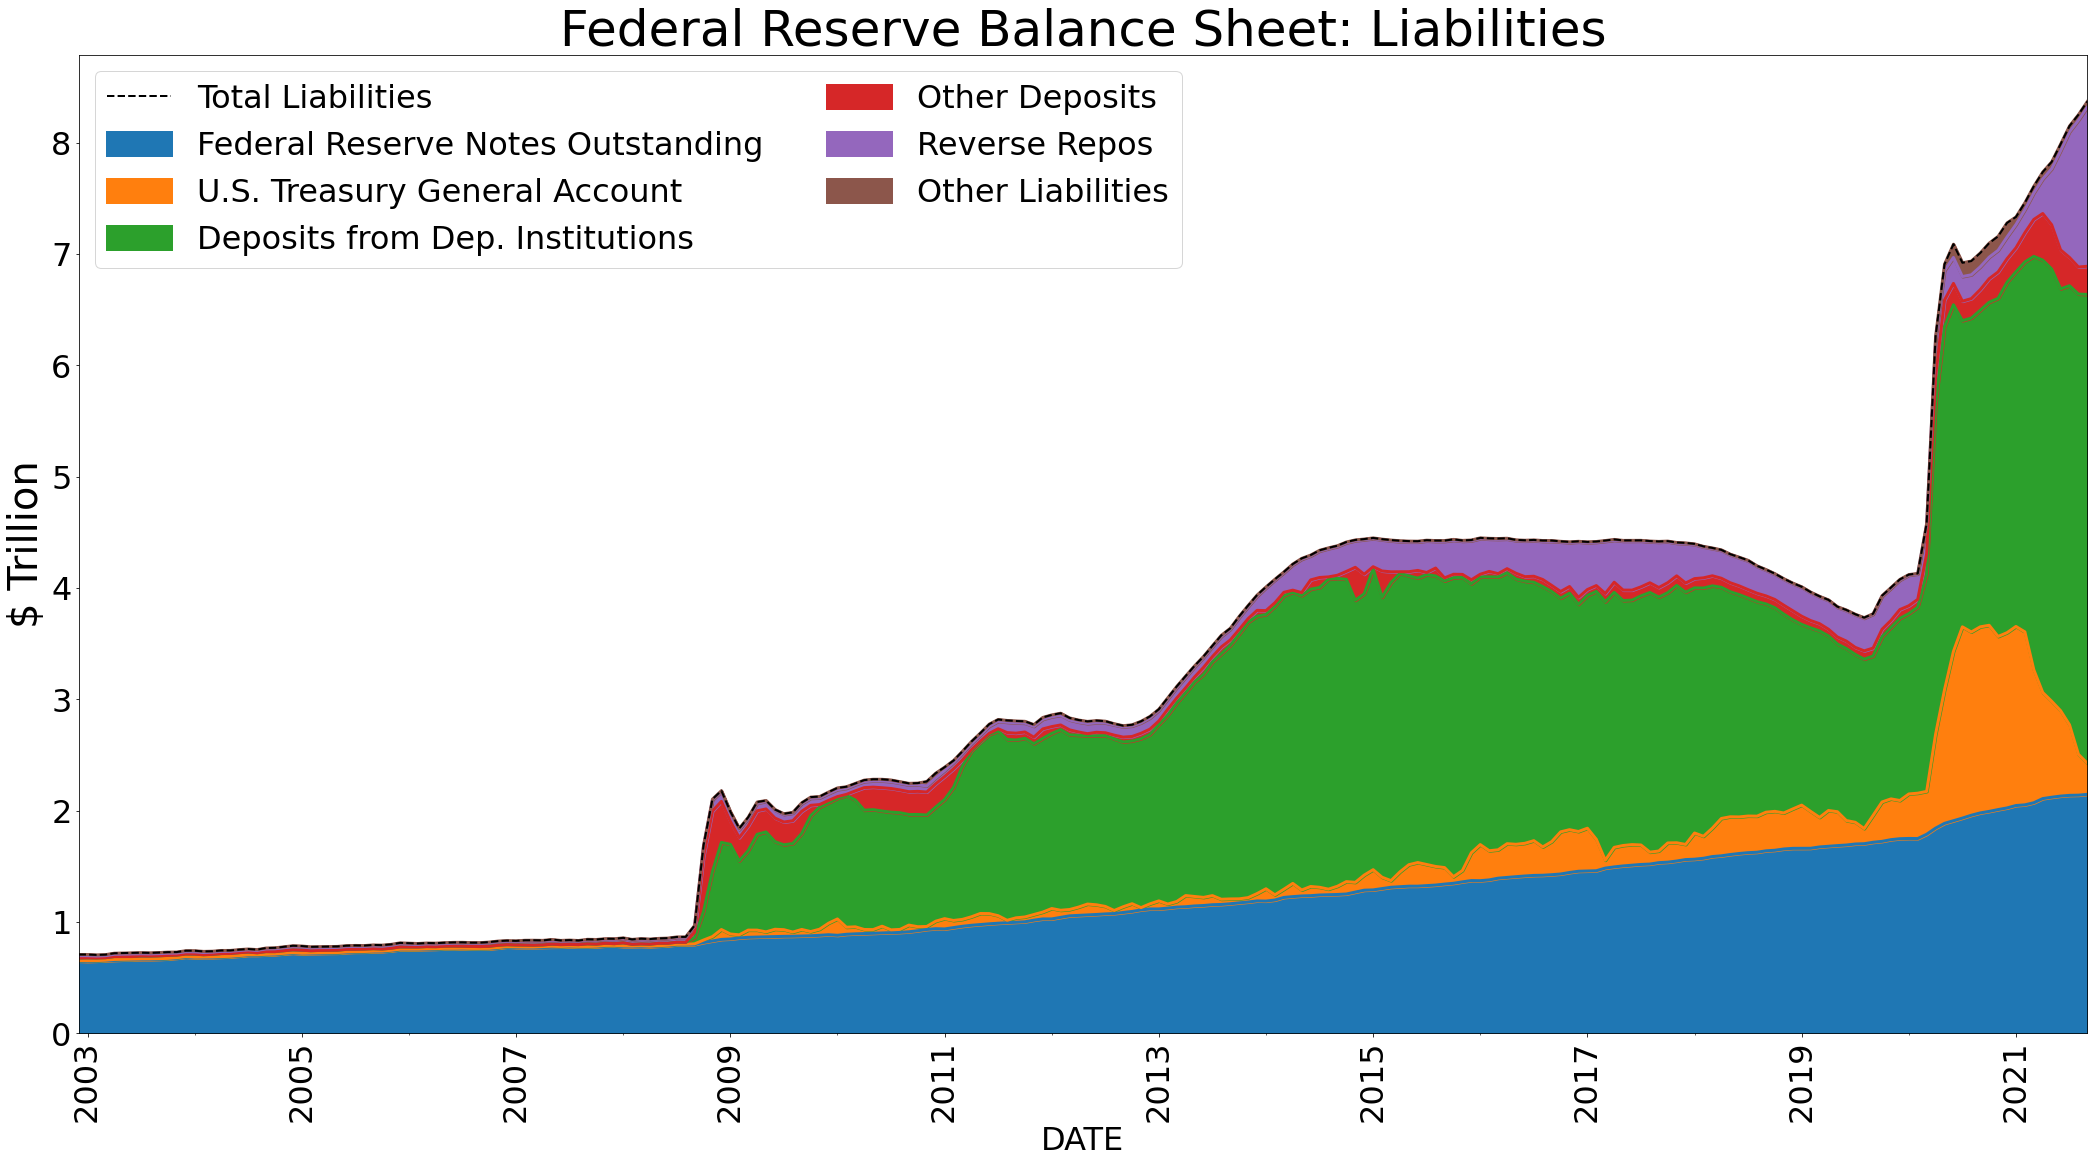

In [9]:
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
plot_data[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
# change y vals from mil to tril
total_var = "Total Liabilities"
plot_data[total_var].plot.line(linewidth = 2, 
                             ax = ax, c = "k",
                             label = total_var, ls = "--")
plt.xticks(rotation = 90)
ax.legend(loc=2, ncol = 2)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Balance Sheet: Liabilities", fontsize = 50)
plot_data[[total_var] + account_vars].to_csv("FederalReserveLiabilities.csv")

<ipython-input-10-bd89c59b9c46>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()], fontsize = 45)


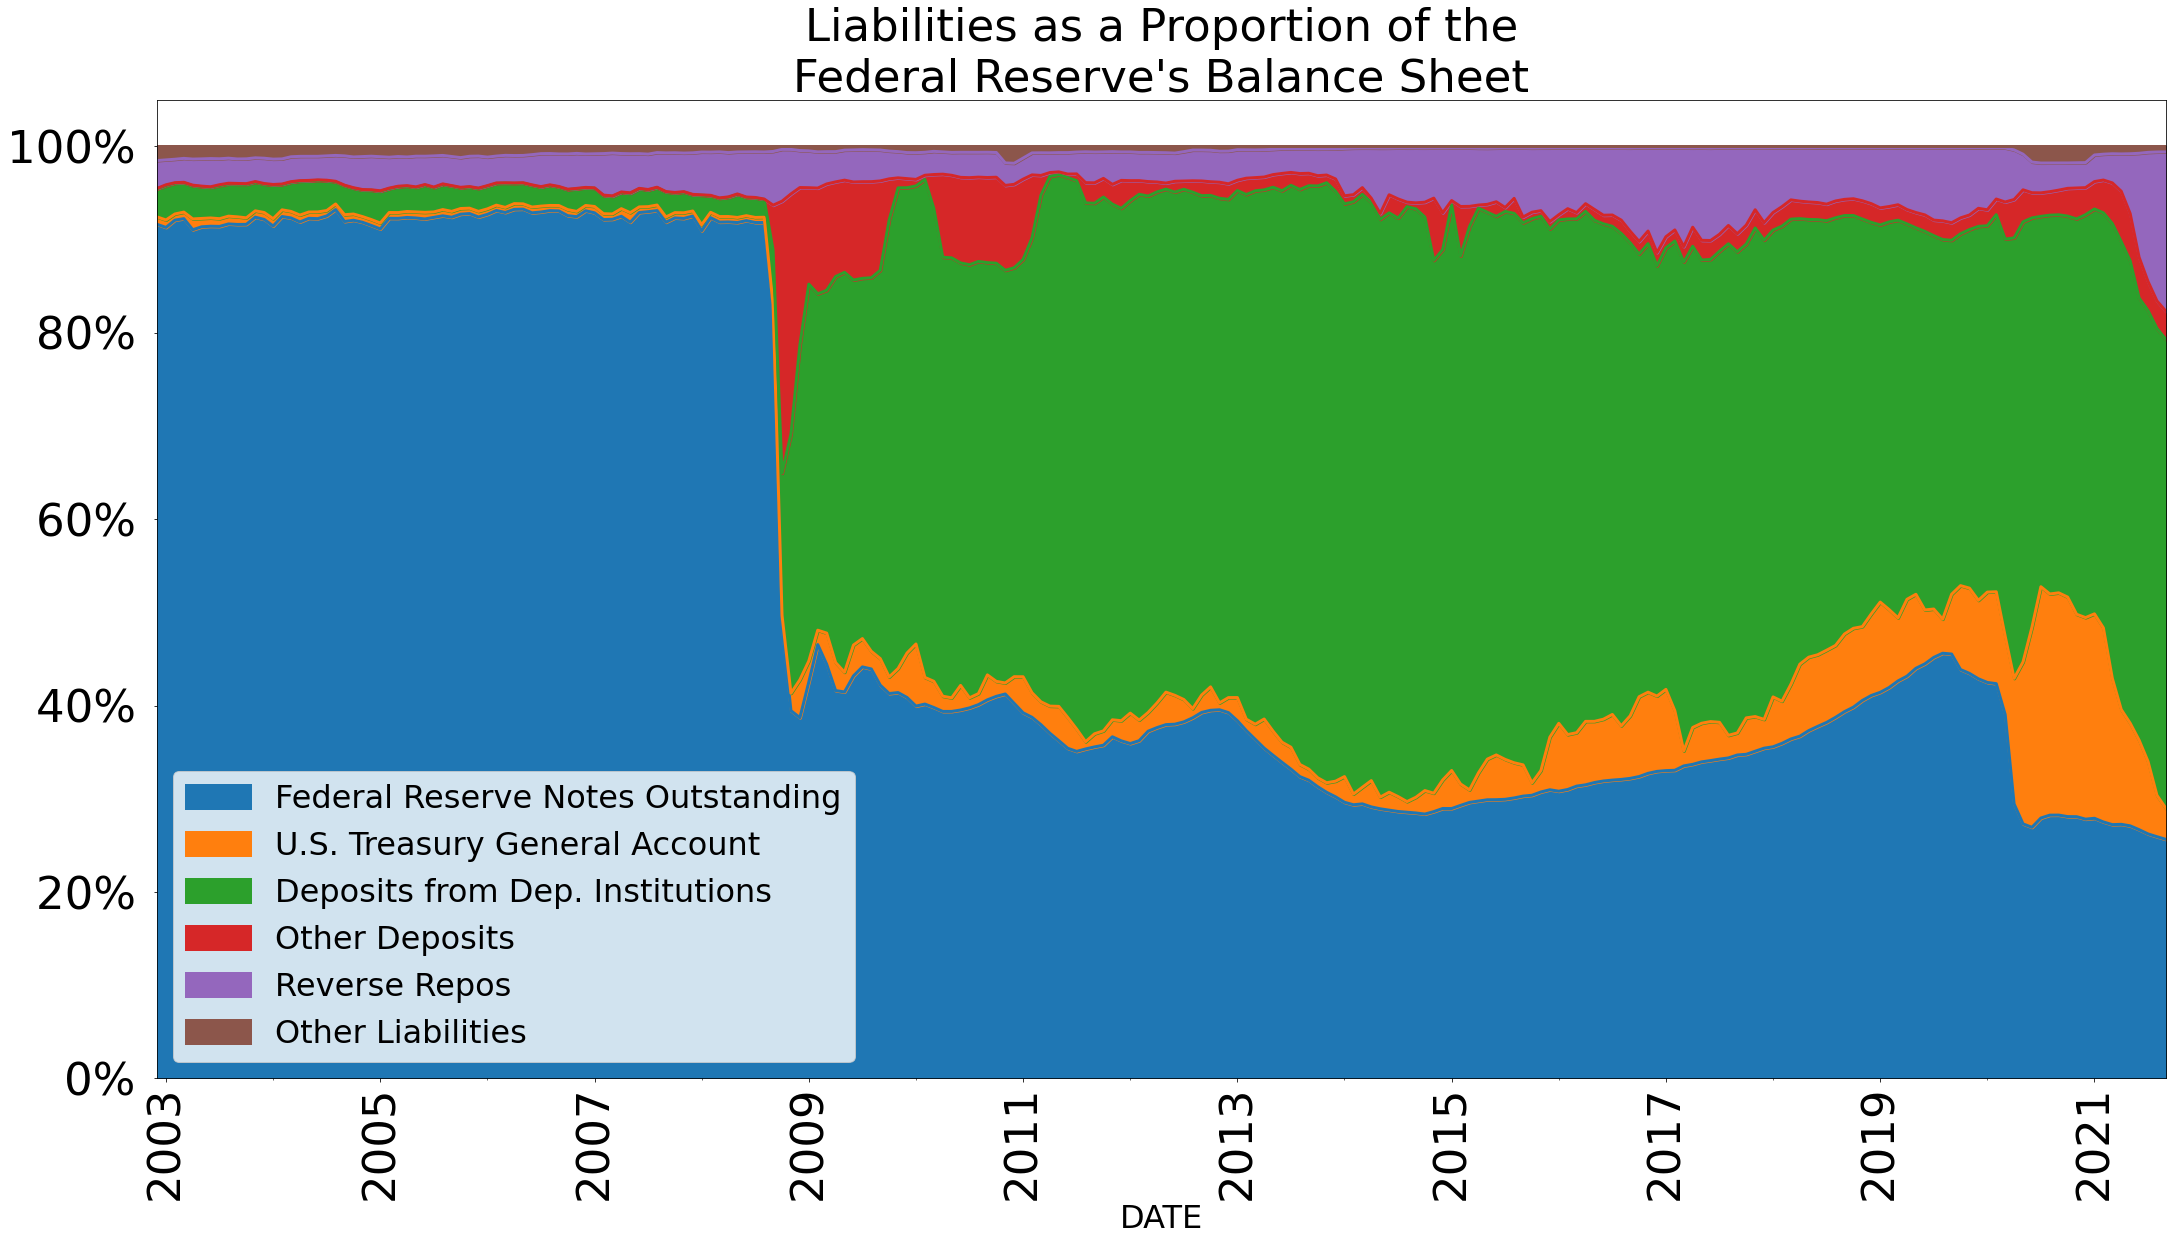

In [10]:
plt.rcParams.update({"font.size":32})
df = plot_data.copy()
for key in account_vars:
    df[key] = df[key].div(df["Total Liabilities"])
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
df[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
plt.xticks(rotation= 90, fontsize = 45)
ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()], fontsize = 45)

#plt.yticks([int(tick * 100) for tick in ax.get_yticks() if tick <1.01])
plt.title("Liabilities as a Proportion of the\nFederal Reserve's Balance Sheet", fontsize =45)
plt.show()


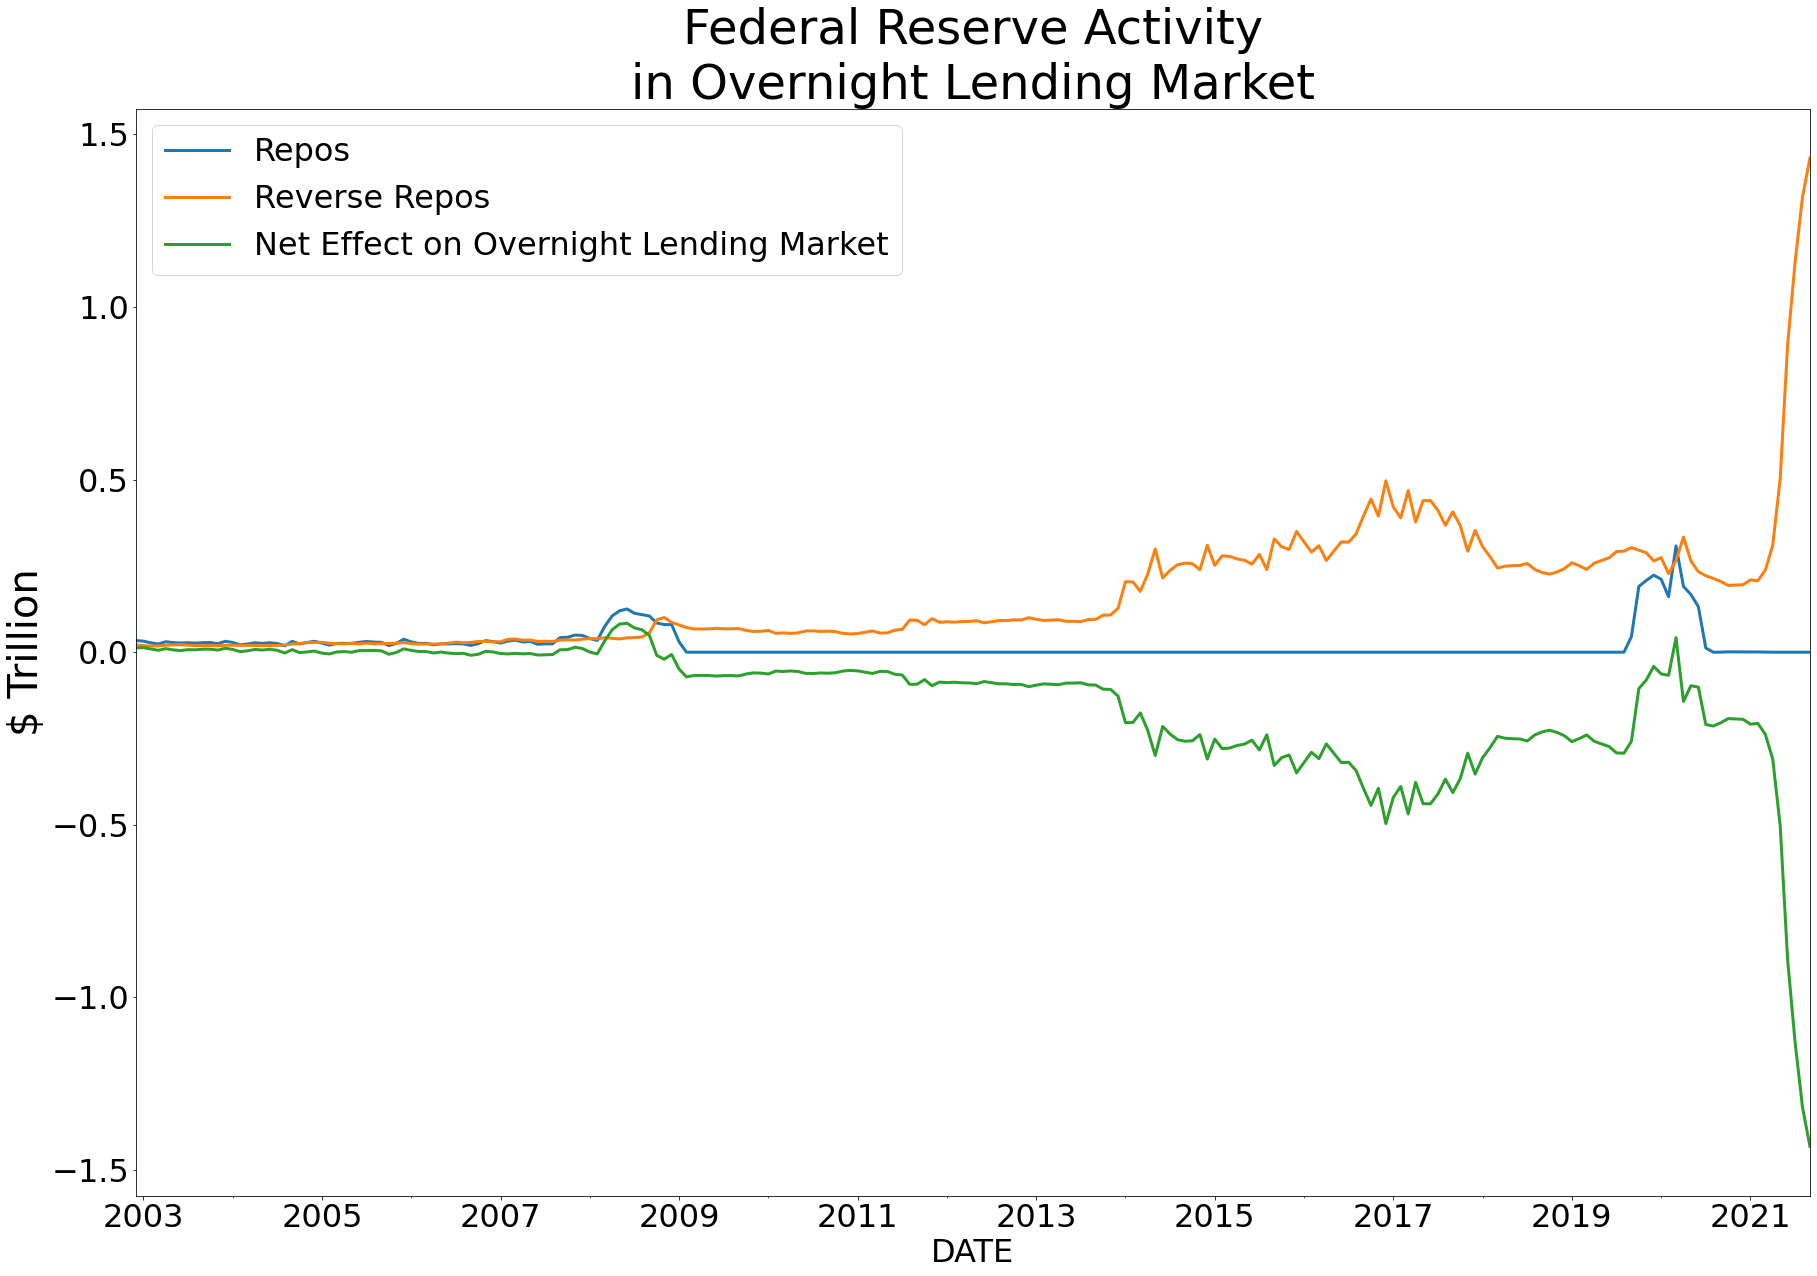

In [11]:
plot_data["Net Effect on Overnight Lending Market"] =\
    plot_data["Repos"].sub(plot_data["Reverse Repos"])
overnight_vars = ["Repos",
                  "Reverse Repos",
                  "Net Effect on Overnight Lending Market"]
fig, ax = plt.subplots(figsize = (30,20))
plot_data[overnight_vars].plot.line(legend=True, linewidth = 3, ax = ax)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Activity\nin Overnight Lending Market", fontsize = 48)
plot_data[["Date"] + overnight_vars].to_json("overnightLending.json", orient="records")


In [15]:
data["Total Liabilities Growth Rate (%)"] = data["Total Liabilities"].pct_change(year)
data["Total Assets Growth Rate (%)"] = data["Total Assets"].pct_change(year)
data["Total Assets Growth Rate Diff (%)"] = data["Total Assets Growth Rate (%)"].diff(year)
data["Total Assets Growth Rate Diff-in-Diff (%)"] = data["Total Assets Growth Rate Diff (%)"].diff(year)

data["Total Liabilities / Currency in Circulation"] = data["Total Liabilities"].div(data["Currency in Circulation ($ Bil)"].mul(1000))
data["Total Assets / Currency in Circulation"] = data["Total Assets"].div(data["Currency in Circulation ($ Bil)"].mul(1000))
data["Currency in Circulation / Total Assets"] = data["Currency in Circulation ($ Bil)"].mul(1000).div(data["Total Assets"])
data["Currency in Circulation / Total Assets Diff"] = data["Currency in Circulation / Total Assets"].diff(year)
data["Currency in Circulation / Total Assets Diff-in-Diff"] = data["Currency in Circulation / Total Assets Diff"].diff(year)
data["Currency in Circulation / Total Liabilities"] = data["Currency in Circulation ($ Bil)"].mul(1000).div(data["Total Liabilities"])
data["Currency in Circulation / Total Liabilities Diff"] = data["Currency in Circulation / Total Liabilities"].diff(year)

data["Log Total Liabilities"] = np.log(data["Total Liabilities"])
data["Log Total Assets"] = np.log(data["Total Assets"])
#data["Currency in Circulation / Total Liabilities %"] = data["Currency in Circulation / Total Liabilities"].pct_change()


In [16]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
data

,Total Assets,"Balance Sheet Securities, Prem-Disc, Repos, and Loans",Securities Held Outright,U.S. Treasuries Held Outright,Federal Agency Debt Securities,Mortgage-Backed Securities,Repos,Central Bank Liquidity Swaps,Direct Lending,Unamortized Security Premiums,...,Total Assets Growth Rate (%),Total Assets Growth Rate Diff (%),Total Assets Growth Rate Diff-in-Diff (%),Total Liabilities / Currency in Circulation,Total Assets / Currency in Circulation,Currency in Circulation / Total Assets,Currency in Circulation / Total Assets Diff,Currency in Circulation / Total Assets Diff-in-Diff,Currency in Circulation / Total Liabilities,Currency in Circulation / Total Liabilities Diff
DATE,,,,,,,,,,,,,,,,,,,,,
2002-12-31,725800.50,672844.50,629409.50,629399.50,10.0,0.00,33625.00,0.0,52.00,10811.00,...,NaN,NaN,NaN,1.046535,1.072920,0.932036,NaN,NaN,0.955534,NaN
2003-01-31,724718.40,671196.20,629416.00,629406.00,10.0,0.00,32100.00,0.0,19.40,10688.00,...,NaN,NaN,NaN,1.041374,1.066686,0.937483,NaN,NaN,0.960270,NaN
2003-02-28,721326.00,668666.25,631911.75,631901.75,10.0,0.00,27185.50,0.0,10.50,10571.25,...,NaN,NaN,NaN,1.035709,1.061035,0.942476,NaN,NaN,0.965522,NaN
2003-03-31,723651.25,672446.00,639168.25,639158.25,10.0,0.00,23625.00,0.0,11.00,10619.25,...,NaN,NaN,NaN,1.033573,1.058878,0.944396,NaN,NaN,0.967518,NaN
2003-04-30,736926.40,685518.60,645508.60,645498.60,10.0,0.00,30350.20,0.0,31.80,10574.40,...,NaN,NaN,NaN,1.047029,1.072587,0.932326,NaN,NaN,0.955083,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,7866893.25,7709974.25,7291913.75,5063447.75,2347.0,2226119.00,11.75,642.5,81423.00,349622.50,...,0.132325,-0.662117,-1.565150,3.610492,3.628665,0.275583,-0.002173,0.167477,0.276971,-0.002350
2021-06-30,8026555.20,7874851.20,7450341.40,5149903.00,2347.0,2298091.20,0.00,516.0,87694.60,350797.60,...,0.126094,-0.729082,-1.694133,3.665537,3.683695,0.271467,-0.002864,0.175099,0.272811,-0.003025
2021-07-31,8190356.75,8042917.00,7617340.75,5232755.50,2347.0,2382238.75,0.00,487.0,87349.25,352744.75,...,0.176703,-0.653170,-1.595879,3.728183,3.746297,0.266930,-0.017286,0.157751,0.268227,-0.017582


In [17]:
import pingouin
plot_vars = ["Inflation (PCE)",
             "Unemployment Rate",
             "Inflation Loss",
             "Unemployment Loss",
             "Linear Loss",
             "Loss Function",
             "Effective Federal Funds Rate (%)",
             "Currency in Circulation Growth Rate (%)",
             "Currency in Circulation / Total Assets",
             "Total Assets Growth Rate (%)"]
#data[plot_vars].describe().T.to_excel("C:\\Users\\JLCat\\OneDrive\\Documents\\For NDSU\\Projects\\Sound Money Project\\Frederal Reserve QE Framework\\DescriptionStatistics.xls")
#data[plot_vars].describe().corr()
#data[plot_vars].describe().pcorr()

In [18]:
plot_vars = [#Currency in Circulation Growth Rate (%)",
             #"Currency not in Circulation Growth Rate (%)",
             #"5 Year Forward Rate",
             #"Inflation (CPI)",
             #"Unemployment Rate Diff",
             #"Loss Function Diff",
            #"Unemployment Loss Diff",
            #"Inflation Loss Diff",
            #"Linear Loss Diff",
            #"Unemployment Loss Sq Diff",
            #"Inflation Loss Sq Diff",
            "Linear Loss Diff",
    #"Currency in Circulation % Change Velocity",
             #"Nominal GDP Growth Rate (%)",
             #"Real GDP Growth Rate (%)",
             "Effective Federal Funds Rate Diff (%)",
             #"30 Year Treasury Rate (%)",
             #"1 Month Treasury Rate (%)",
             #"S&P Growth Rate (%)",
             "Currency in Circulation / Total Assets Diff",
             #Total Assets Growth Rate (%)",
             "VIX Diff"
]
dag_df = data[plot_vars].dropna().rename(columns={key: key.replace(" ", "\n") for key in plot_vars}).loc["2008-10-01":"2020-08-01"]
dag_df.pcorr().round(2)

,Linear\nLoss\nDiff,Effective\nFederal\nFunds\nRate\nDiff\n(%),Currency\nin\nCirculation\n/\nTotal\nAssets\nDiff,VIX\nDiff
Linear\nLoss\nDiff,1.00,0.44,0.09,0.18
Effective\nFederal\nFunds\nRate\nDiff\n(%),0.44,1.00,0.71,-0.29
Currency\nin\nCirculation\n/\nTotal\nAssets\nDiff,0.09,0.71,1.00,-0.06
VIX\nDiff,0.18,-0.29,-0.06,1.00


In [19]:
data["Inflation (CPI)"]

DATE
2002-12-31         NaN
2003-01-31    2.480271
2003-02-28    2.757456
2003-03-31    3.146067
2003-04-30    3.025210
                ...   
2021-05-31    4.153135
2021-06-30    4.926507
2021-07-31    5.324508
2021-08-31    5.282594
2021-09-30         NaN
Freq: M, Name: Inflation (CPI), Length: 226, dtype: float64

In [24]:
from pgmpy.estimators import PC
from pgmpy.base import DAG
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import networkx as nx
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams.update({"font.size":20})

from matplotlib.patches import ArrowStyle

def graph_DAG(edges, df, pp, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                keep_controls.append(control)                
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,20))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2000,
                     with_labels=True,  arrows=True,
                     #font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
    pp.savefig(fig, bbox_inches = "tight")  
    plt.close()
    
rename_dct = {"Effective":"FFR",
             "Currency":"C/A",
             "Function":"LF",
             "Inflation":"$\pi$",
             "Unemployment":"U"}
diffs = ["", " Diff", " Diff-in-Diff"]
# diffs = [" Diff"]
pp = PdfPages("MacroDAGs.pdf")
for diff in diffs:
    plot_vars_dct = {0: ["Loss Function" + diff,
                         "Effective Federal Funds Rate" +diff + " (%)",
                         "Currency in Circulation / Total Assets" + diff],
#                      1:["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Loss Function" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
                     2:["Unemployment Loss Sq" + diff,
                        "Inflation Loss Sq" + diff,
                        "Effective Federal Funds Rate" +diff + " (%)",
                        "Currency in Circulation / Total Assets" + diff],
#                      3:["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Unemployment Loss Sq" + diff,
#                         "Inflation Loss Sq" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
                        }

    sig = 0.05
    variant = "parallel"
    ci_test = "pearsonr"
    
    for key, plot_vars in plot_vars_dct.items():
                
        var_data = data[plot_vars].dropna()
        for key in var_data:
            for rename_key in rename_dct:
                if rename_key in key:
                    var_data.rename(columns={key:rename_dct[rename_key] + diff}, inplace = True)
        data1 = var_data.dropna().rename(columns={key: key.replace(" ", "\n") for key in plot_vars}).loc[:"2008-10-31"]
        start1 = str(list(data1.index)[0])[:10]
        data2 = var_data.dropna().rename(columns={key: key.replace(" ", "\n") for key in plot_vars}).loc["2008-10-31":"2020-08-31"]
        
        dfs = {start1 + " to 2008-09-30":data1,
               "2008-10-31 to 2020-07-31": data2}

        for dates, dag_df in dfs.items():
            print(key, dates)
            dag_df = dag_df.dropna()#.rename(columns={key: key.replace("\nDiff", "") for key in dag_df.keys()})
            keys = dag_df.keys()
            c = PC(dag_df)
            max_cond_vars = len(keys) - 2
    #         print(dag_df.index)

            model = c.estimate(return_type = "dag",variant= variant, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = ci_test)
            edges = model.edges()
            pcorr = dag_df.pcorr()
            weights = {}
    #         for edge in edges:
    #             print(edge, ":",pcorr[edge[0]].loc[edge[1]])
    #         skel, sep_sets = c.build_skeleton(variant = variant, ci_test = ci_test, significance_level = sig, 
    #                            max_cond_vars = max_cond_vars)


            graph_DAG(edges, dag_df, pp = pp, title = diff.replace(" ", "") + "\n" + dates)
pp.close()

Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 43.79it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]

Currency in Circulation / Total Assets 2003-01-31 to 2008-09-30



Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  8.97it/s]

Currency in Circulation / Total Assets 2008-10-31 to 2020-07-31



Working for n conditional variables: 1:  50%|██████████████████████                      | 1/2 [00:00<00:00, 33.42it/s]

Currency in Circulation / Total Assets 2003-01-31 to 2008-09-30


Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  9.08it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 1:  50%|██████████████████████                      | 1/2 [00:00<00:00, 28.65it/s]

Currency in Circulation / Total Assets 2008-10-31 to 2020-07-31


Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  8.29it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 32.44it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  8.72it/s]

Currency in Circulation / Total Assets Diff 2004-01-31 to 2008-09-30



Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 52.78it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  7.45it/s]

Currency in Circulation / Total Assets Diff 2008-10-31 to 2020-07-31



Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 10.22it/s]

Currency in Circulation / Total Assets Diff 2004-01-31 to 2008-09-30


Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 10.22it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 1:  50%|██████████████████████                      | 1/2 [00:00<00:00, 29.24it/s]

Currency in Circulation / Total Assets Diff 2008-10-31 to 2020-07-31


Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 55.74it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 15.40it/s]

Currency in Circulation / Total Assets Diff-in-Diff 2005-01-31 to 2008-09-30



Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 60.42it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  8.58it/s]

Currency in Circulation / Total Assets Diff-in-Diff 2008-10-31 to 2020-07-31



Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 26.64it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 20.77it/s]

Currency in Circulation / Total Assets Diff-in-Diff 2005-01-31 to 2008-09-30



Working for n conditional variables: 1:  50%|██████████████████████                      | 1/2 [00:00<00:00, 45.74it/s]

Currency in Circulation / Total Assets Diff-in-Diff 2008-10-31 to 2020-07-31


Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  6.17it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  5.04it/s]


In [34]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import copy
import pingouin
from scipy.stats import pearsonr
p_val = .01
def formatted_scatter_matrix(data, pp):  
    # Create a figure showing scatterplots given in scatter_cats  
    fig_len = 12  
    fig, ax = plt.subplots(figsize = ((fig_len, fig_len)))  
    # Use fig_len to dictate fig_size, adjust size of font, size of dots, etc...  
    num_vars = len(data.keys())  
    fontsize = 26
    plt.rcParams.update({'font.size': fontsize})  
    pd.plotting.scatter_matrix(data,alpha = .5, s = 200 / num_vars, ax=ax)  
    # tight layout improves layout of text and plots in the figure  
    plt.tight_layout()  
    plt.show()  
    pp.savefig(fig, bbox_inches = "tight")  
    plt.close() 

def corr_matrix_heatmap(data, pp, title = "Correlation"):  
    #Create a figure to visualize a corr matrix  
    fig, ax = plt.subplots(figsize=(12,12))  
    # use ax.imshow() to create a heatmap of correlation values  
    # seismic mapping shows negative values as blue and positive values as red  
    im = ax.imshow(data, norm = plt.cm.colors.Normalize(-1,1), cmap = "seismic")  
    # create a list of labels, stacking each word in a label by replacing " "  
    # with "\n"  
    labels = data.keys()  
    num_vars = len(labels)  
    tick_labels = [lab.replace(" ", "\n") for lab in labels]  
    # adjust font size according to the number of variables visualized  
    tick_font_size = 120 / num_vars  
    val_font_size = 200 / num_vars  
    plt.rcParams.update({'font.size': tick_font_size}) 
    # prepare space for label of each column  
    x_ticks = np.arange(num_vars)  
    # select labels and rotate them 90 degrees so that they are vertical  
    plt.xticks(x_ticks, tick_labels, fontsize = tick_font_size, rotation = 90)  
    # prepare space for label of each row  
    y_ticks = np.arange(len(labels))  
    # select labels  
    plt.yticks(y_ticks, tick_labels, fontsize = tick_font_size)  
    # show values in each tile of the heatmap  
    for i in range(len(labels)):  
        for j in range(len(labels)):  
            text = ax.text(i, j, str(round(data.values[i][j],2)),  
                           fontsize= val_font_size, ha="center",   
                           va="center", color = "k")#, alpha = 1 - round(abs(data.values[i][j]),2))  
    #Create title with Times New Roman Font  
    title_font = {"fontname":"Times New Roman"}  
    plt.title(title, fontsize = 50, **title_font)  
    #Call scale to show value of colors 
    cbar = fig.colorbar(im)
    plt.show()
    pp.savefig(fig, bbox_inches="tight")
    plt.close()

def build_skeleton(df, undirected_graph):    
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        c_used = copy.copy(controls_used)
        for c_var in control_vars:
            if y not in undirected_graph[x]:
                break
            c_used.append(c_var)
            test = df.partial_corr(x = x, y = y, covar=c_used,
                                  method = "pearson")
            if test["p-val"].values[0] > p_val: 

                undirected_graph[x].remove(y)
                #breakout of the for 
                break
            else:
                remaining_controls = copy.copy(control_vars)
                remaining_controls.remove(c_var)
                check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)
    d_sep = {}
    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            d_sep[(x,y)] = []

            if x != y:
            # first check for correlation with no controls
                test = df.partial_corr(x = x, y = y, covar = None,method = "pearson") 
                if test["p-val"].values[0] > p_val:
                    undirected_graph[x].remove(y)
            # if correlated check for deseparation controlling for other variables
                else:
                ############## make recursive function #############

                    control_vars = [z for z in df.keys() if z != y and z != x]
                    check_remaining_controls(control_vars, undirected_graph, x, y, [])
    return undirected_graph

def adfuller_df(df, maxlag = 12):
    dct = {}
    for key, val in df.items():
        dct[key] = adfuller(val, maxlag=maxlag, autolag = "aic")[1]#.pvalue
    return dct

def cointegration_df(df):
    dct = {}
    for key1 in df:
        dct[key1] = {}
        for key2 in df:
            if key1 == key2:
                dct[key1][key2] = np.nan
            else:
                dct[key1][key2] = coint_johansen(df[[key1,key2]], det_order=0, k_ar_diff=1).lr1
    return pd.DataFrame(dct)
# undirected_graph = build_skeleton(df, undirected_graph)                                   
# undirected_graph


In [41]:
diffs = ["", " Diff", " Diff-in-Diff"]
adf_dct = {}
for diff in diffs:
    plot_vars_dct = {"Aggregated": ["Effective Federal Funds Rate" +diff + " (%)",
                         "Currency in Circulation / Total Assets" + diff,
                        "Loss Function" + diff],
#                      1:["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Loss Function" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
                     "Decomposed":["Effective Federal Funds Rate" +diff + " (%)",
                        "Currency in Circulation / Total Assets" + diff,
                         "Unemployment Loss" + diff,
                        "Inflation Loss" + diff]}
    adf_dct[diff]={}
    for i in plot_vars_dct:
        var_data = data[plot_vars_dct[i]].dropna()#.loc["2009-07-31":"2020-03-31"]#.resample("Q").last()
        adf_dct[diff][i] = {}
        for j in range(0,12):
            adfuller_stats = adfuller_df(var_data.iloc[j::12], 1) 
            adf_dct[diff][i][j]=adfuller_stats
#             print(j,pd.DataFrame(adfuller_stats, index = [0]), sep = "\n")
        print(pd.DataFrame(adf_dct[diff][i]).T)
            

    Effective Federal Funds Rate (%)  Currency in Circulation / Total Assets  \
0                           0.074711                                0.651312   
1                           0.037630                                0.671048   
2                           0.065469                                0.663705   
3                           0.087721                                0.654825   
4                           0.093672                                0.645882   
5                           0.079786                                0.656249   
6                           0.063737                                0.668801   
7                           0.061710                                0.682987   
8                           0.060401                                0.679887   
9                           0.083890                                0.596107   
10                          0.110775                                0.532607   
11                          0.104953    

                                               Effective Federal Funds Rate (%)  \
Effective Federal Funds Rate (%)                                            NaN   
Currency in Circulation / Total Assets  [13.946345400220848, 6.548269650035164]   
Loss Function                            [5.669109634342782, 0.960926290189521]   

                                          Currency in Circulation / Total Assets  \
Effective Federal Funds Rate (%)         [13.946345400220848, 6.548269650035164]   
Currency in Circulation / Total Assets                                       NaN   
Loss Function                           [10.831561267944053, 2.8207913257494557]   

                                                                   Loss Function  
Effective Federal Funds Rate (%)          [5.669109634342782, 0.960926290189521]  
Currency in Circulation / Total Assets  [10.831561267944053, 2.8207913257494557]  
Loss Function                                                                NaN 

<ipython-input-33-dffa8ba66cfa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Constant"] = 1
<ipython-input-33-dffa8ba66cfa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Constant"] = 1
<ipython-input-33-dffa8ba66cfa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

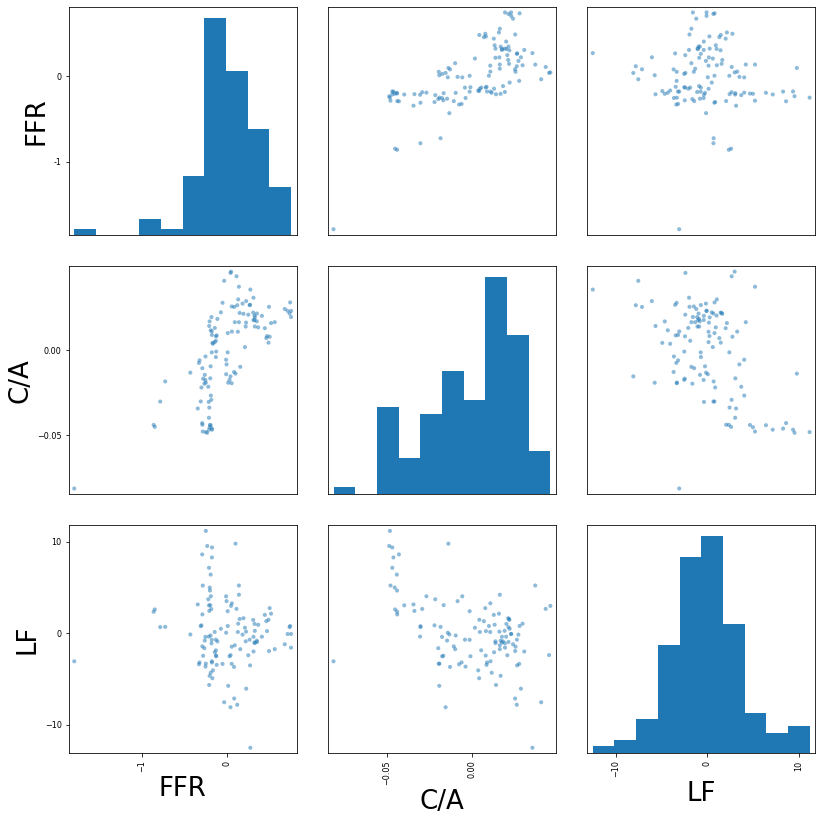

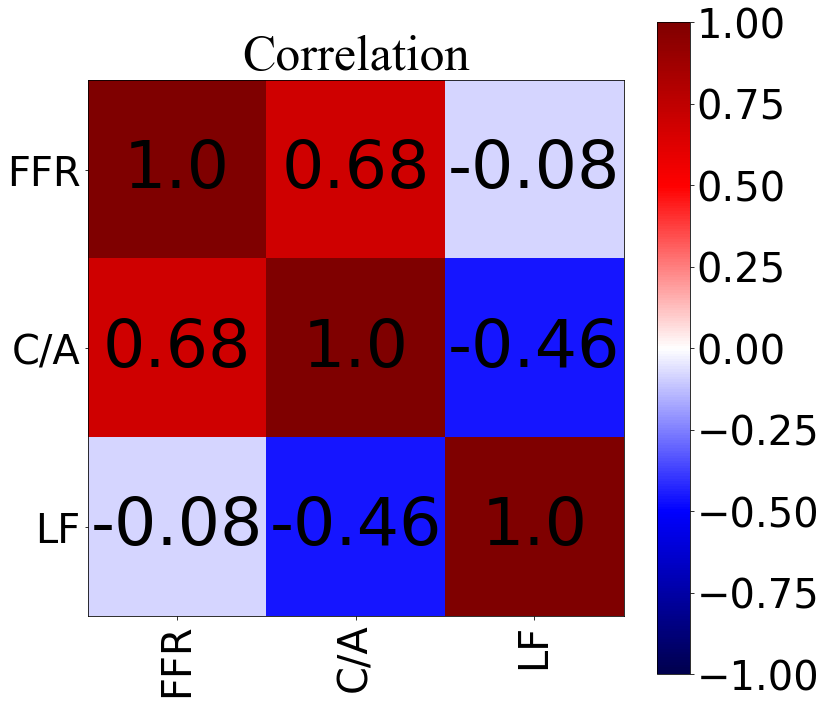

              FFR           C/A            LF
FFR  0.000000e+00 -2.713175e-17 -3.654031e-01
C/A -2.713175e-17  0.000000e+00 -1.770617e-07
LF  -3.654031e-01 -1.770617e-07  0.000000e+00


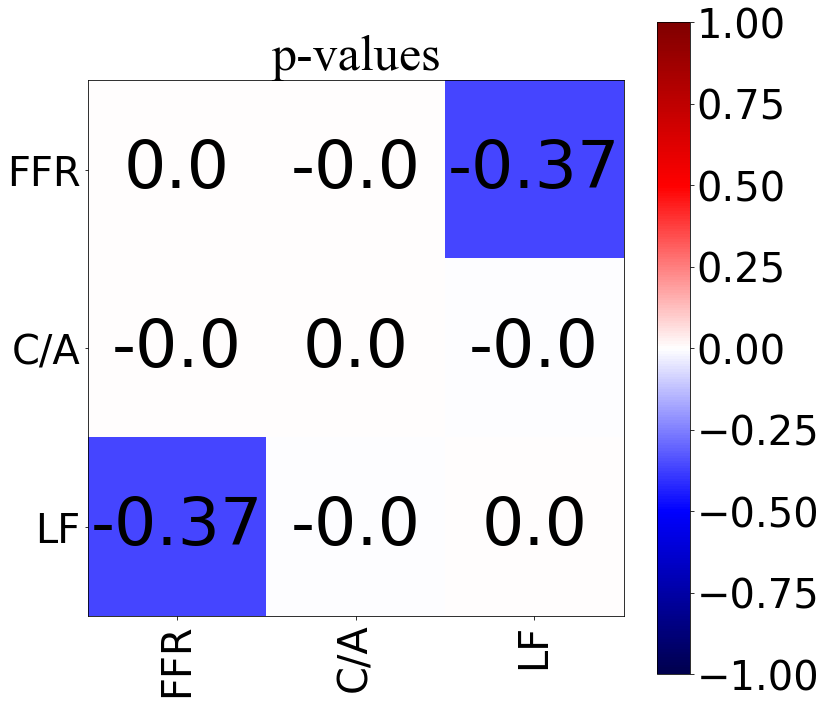

                                                Effective Federal Funds Rate (%)  \
Effective Federal Funds Rate (%)                                             NaN   
Currency in Circulation / Total Assets   [13.946345400220848, 6.548269650035164]   
Unemployment Loss                       [3.853024519786741, 0.37218665816275526]   
Inflation Loss                           [17.602558235764985, 1.965796546358884]   

                                         Currency in Circulation / Total Assets  \
Effective Federal Funds Rate (%)        [13.946345400220848, 6.548269650035164]   
Currency in Circulation / Total Assets                                      NaN   
Unemployment Loss                       [11.182015522845045, 2.291819411751014]   
Inflation Loss                            [19.4931652443439, 2.248291712248931]   

                                                               Unemployment Loss  \
Effective Federal Funds Rate (%)        [3.853024519786741, 0.37218665816275526

<ipython-input-33-dffa8ba66cfa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Constant"] = 1
<ipython-input-33-dffa8ba66cfa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Constant"] = 1
<ipython-input-33-dffa8ba66cfa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

                            OLS Regression Results                            
Dep. Variable:                    FFR   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     110.4
Date:                Thu, 23 Sep 2021   Prob (F-statistic):           6.32e-38
Time:                        20:14:42   Log-Likelihood:                -41.975
No. Observations:                 117   AIC:                             93.95
Df Residuals:                     112   BIC:                             107.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FFR Lag        0.3475      0.170      2.038      0.0

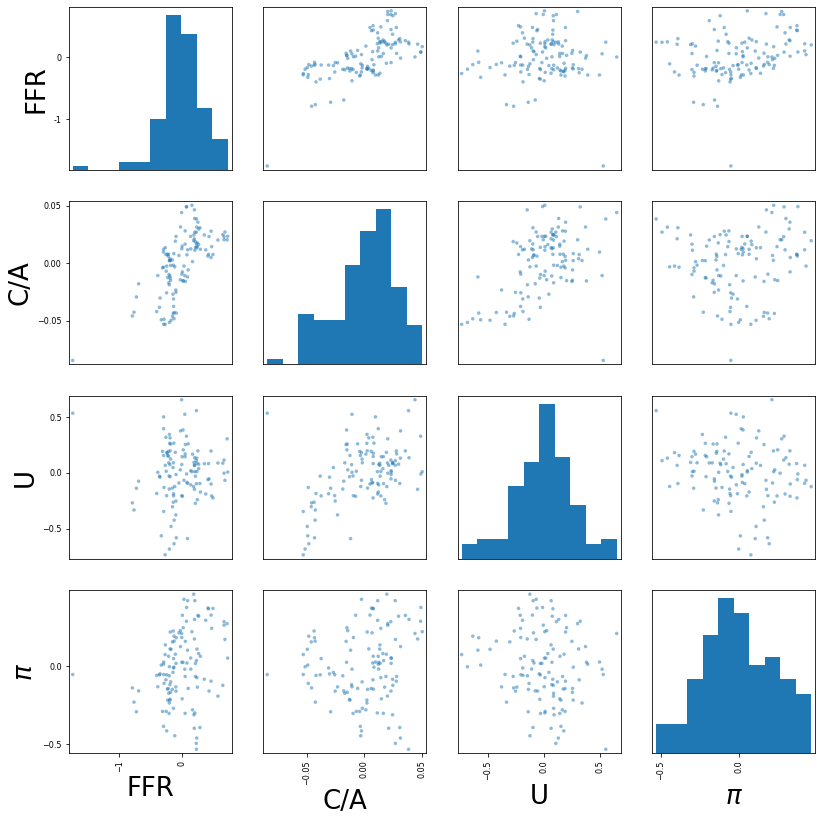

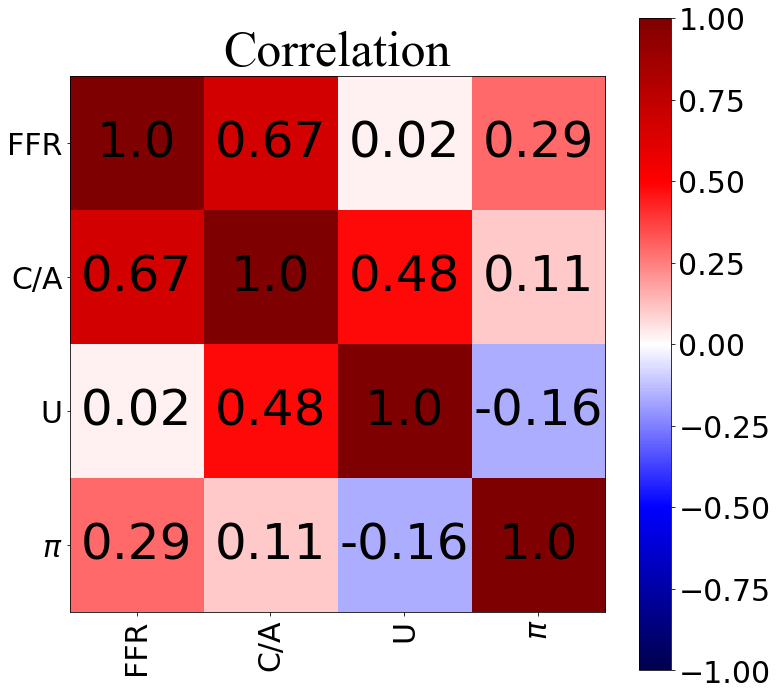

                FFR           C/A             U     $\pi$
FFR    0.000000e+00 -2.150031e-16 -7.897767e-01 -0.001497
C/A   -2.150031e-16  0.000000e+00 -5.224044e-08 -0.259485
U     -7.897767e-01 -5.224044e-08  0.000000e+00 -0.092137
$\pi$ -1.496927e-03 -2.594851e-01 -9.213662e-02  0.000000


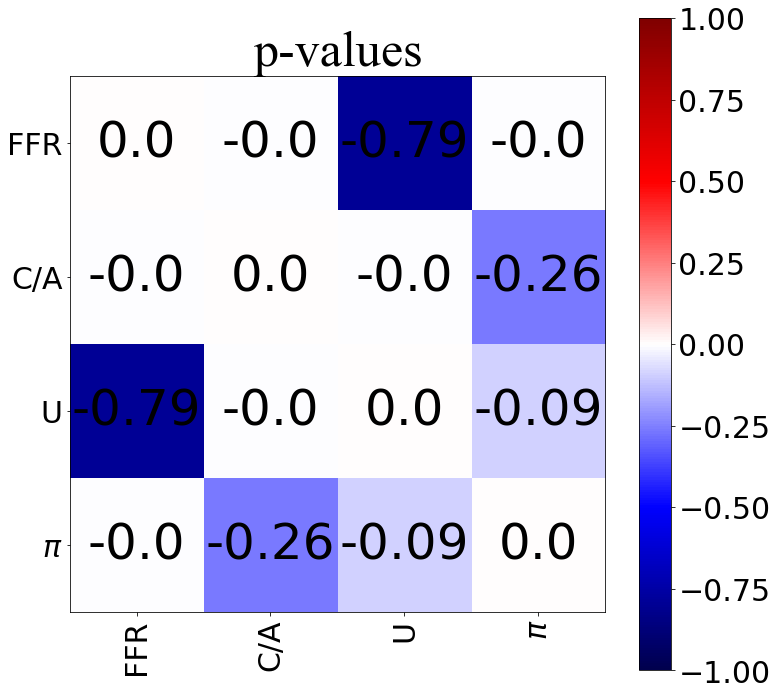

       Aggregated  Decomposed
FFR      0.771649    0.790429
C/A      0.682980    0.658672
LF       0.975890         NaN
U             NaN    0.981863
$\pi$         NaN    0.162641
                                                Effective Federal Funds Rate Diff (%)  \
Effective Federal Funds Rate Diff (%)                                             NaN   
Currency in Circulation / Total Assets Diff     [85.8754857225227, 4.348845284576454]   
Loss Function Diff                           [23.668184249770537, 1.6788034997597174]   

                                            Currency in Circulation / Total Assets Diff  \
Effective Federal Funds Rate Diff (%)            [85.87548572252277, 4.348845284576454]   
Currency in Circulation / Total Assets Diff                                         NaN   
Loss Function Diff                               [99.47162925545827, 17.34471560280531]   

                                                                  Loss Function Diff  
Effective F

<ipython-input-33-dffa8ba66cfa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Constant"] = 1
<ipython-input-33-dffa8ba66cfa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Constant"] = 1
<ipython-input-33-dffa8ba66cfa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

                            OLS Regression Results                            
Dep. Variable:               C/A Diff   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     15.73
Date:                Thu, 23 Sep 2021   Prob (F-statistic):           1.29e-08
Time:                        20:14:52   Log-Likelihood:                 233.34
No. Observations:                 117   AIC:                            -458.7
Df Residuals:                     113   BIC:                            -447.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
FFR Diff Lag     0.0758      0.012      6.068   

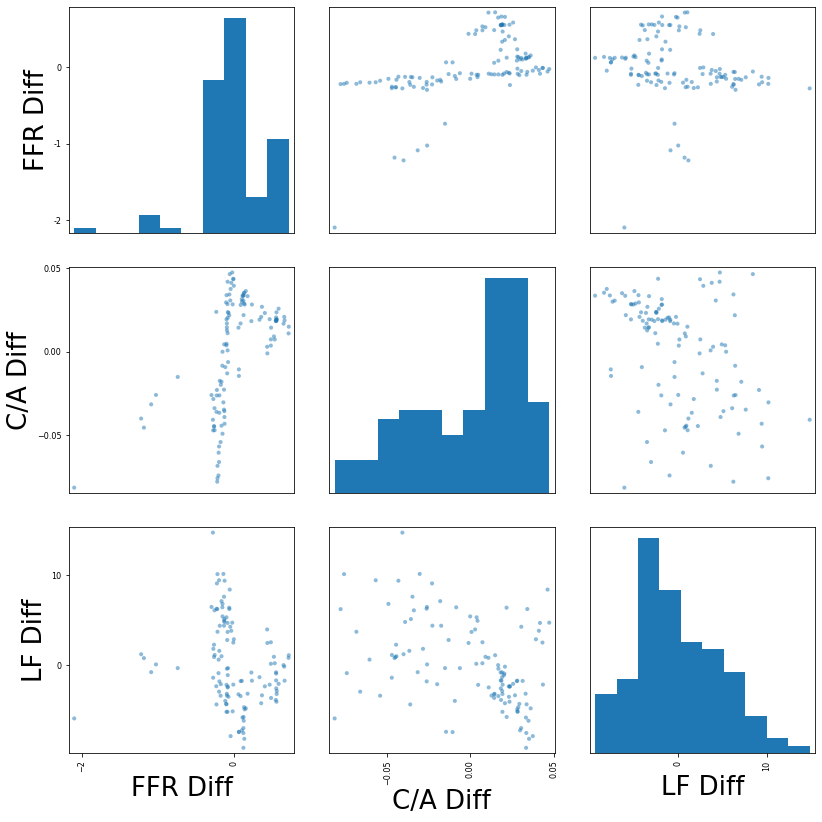

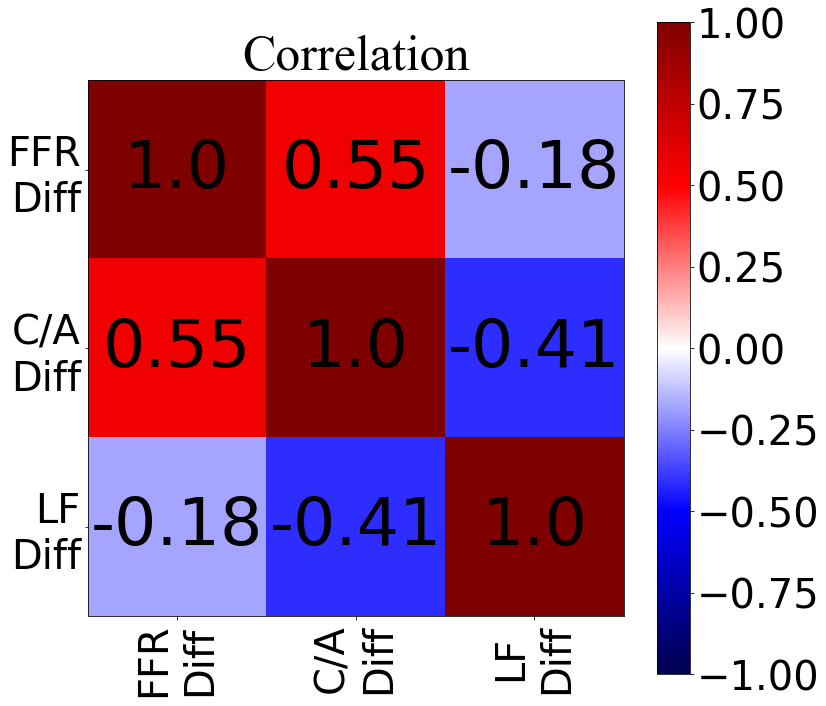

              FFR Diff      C/A Diff   LF Diff
FFR Diff  0.000000e+00 -1.206905e-10 -0.054869
C/A Diff -1.206905e-10  0.000000e+00 -0.000004
LF Diff  -5.486926e-02 -3.574647e-06  0.000000


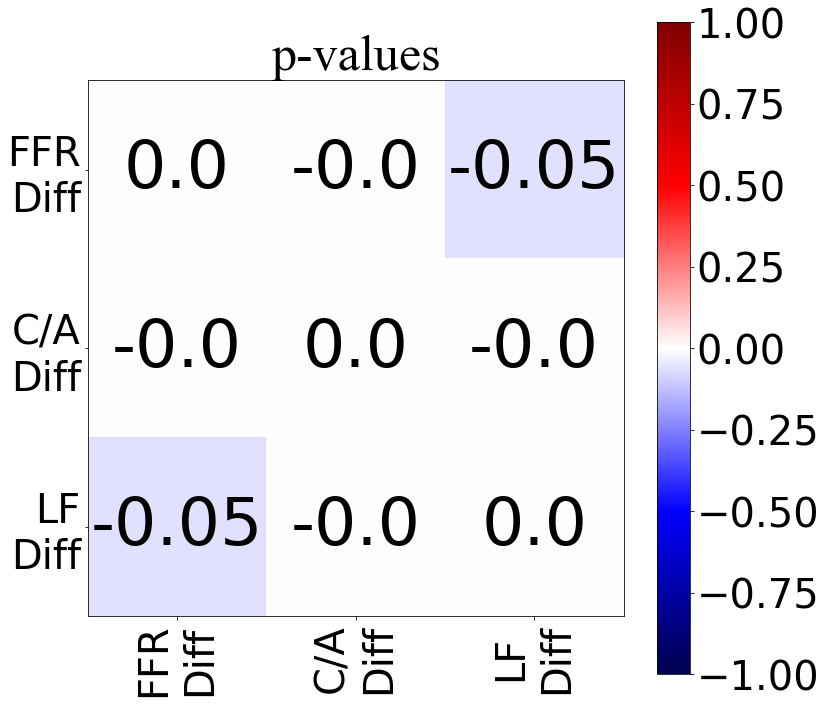

                                                Effective Federal Funds Rate Diff (%)  \
Effective Federal Funds Rate Diff (%)                                             NaN   
Currency in Circulation / Total Assets Diff     [85.8754857225227, 4.348845284576454]   
Unemployment Loss Diff                       [22.092013697037242, 2.4046056559666016]   
Inflation Loss Diff                           [22.506744322116436, 1.246868148402528]   

                                            Currency in Circulation / Total Assets Diff  \
Effective Federal Funds Rate Diff (%)            [85.87548572252277, 4.348845284576454]   
Currency in Circulation / Total Assets Diff                                         NaN   
Unemployment Loss Diff                          [93.98299881303431, 17.088806523640883]   
Inflation Loss Diff                               [85.6498846269946, 9.747500329425167]   

                                                               Unemployment Loss Diff  \
Effective

<ipython-input-33-dffa8ba66cfa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Constant"] = 1
<ipython-input-33-dffa8ba66cfa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Constant"] = 1
<ipython-input-33-dffa8ba66cfa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

                            OLS Regression Results                            
Dep. Variable:             $\pi$ Diff   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     18.15
Date:                Thu, 23 Sep 2021   Prob (F-statistic):           1.63e-11
Time:                        20:14:59   Log-Likelihood:                -28.643
No. Observations:                 117   AIC:                             67.29
Df Residuals:                     112   BIC:                             81.10
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
FFR Diff Lag       0.0830      0.119      0.

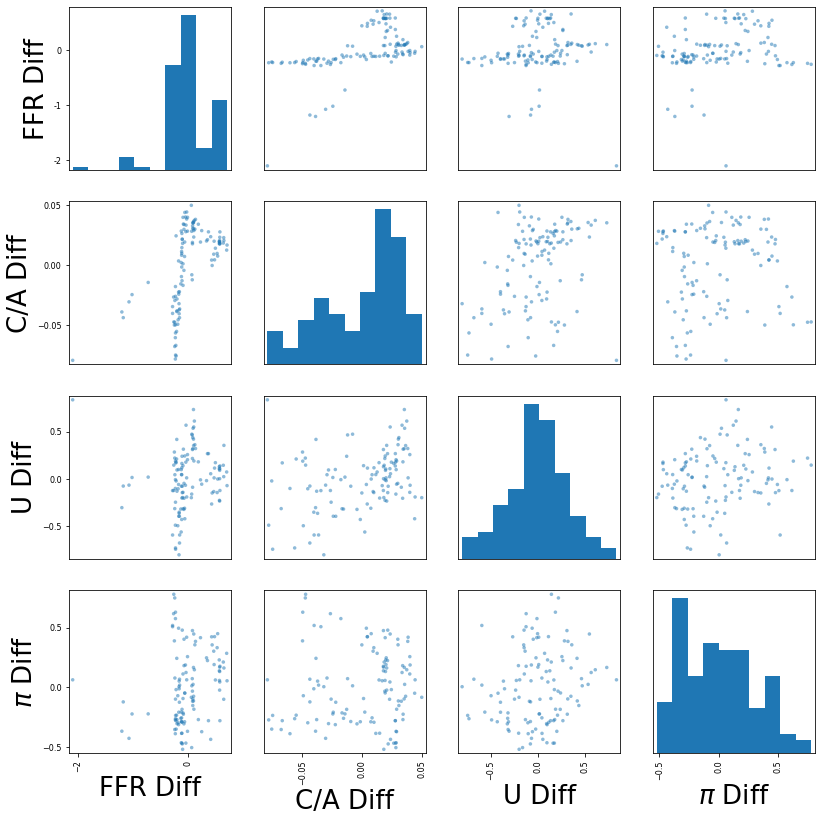

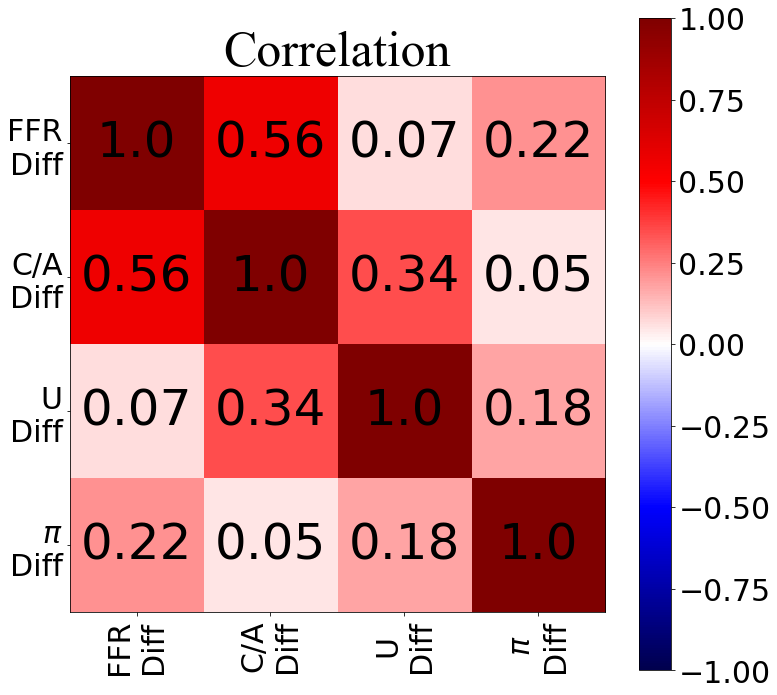

                FFR Diff      C/A Diff    U Diff  $\pi$ Diff
FFR Diff    0.000000e+00 -7.853990e-11 -0.461901   -0.018386
C/A Diff   -7.853990e-11  0.000000e+00 -0.000140   -0.558194
U Diff     -4.619009e-01 -1.404989e-04  0.000000   -0.057652
$\pi$ Diff -1.838613e-02 -5.581942e-01 -0.057652    0.000000


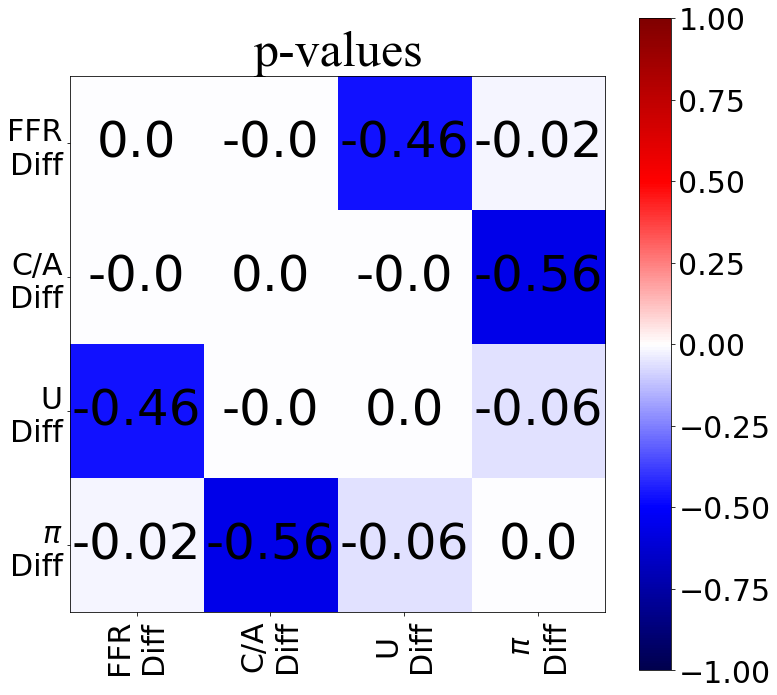

            Aggregated  Decomposed
FFR Diff      0.016658    0.005423
C/A Diff      0.275881    0.263562
LF Diff       0.297704         NaN
U Diff             NaN    0.234200
$\pi$ Diff         NaN    0.371568
                                                   Effective Federal Funds Rate Diff-in-Diff (%)  \
Effective Federal Funds Rate Diff-in-Diff (%)                                                NaN   
Currency in Circulation / Total Assets Diff-in-...        [71.15922148039876, 5.066530055612936]   
Loss Function Diff-in-Diff                                [43.06090856024018, 5.091612312618329]   

                                                   Currency in Circulation / Total Assets Diff-in-Diff  \
Effective Federal Funds Rate Diff-in-Diff (%)                  [71.15922148039871, 5.066530055612936]    
Currency in Circulation / Total Assets Diff-in-...                                                NaN    
Loss Function Diff-in-Diff                                    [61.27330

<ipython-input-33-dffa8ba66cfa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Constant"] = 1
<ipython-input-33-dffa8ba66cfa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Constant"] = 1
<ipython-input-33-dffa8ba66cfa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

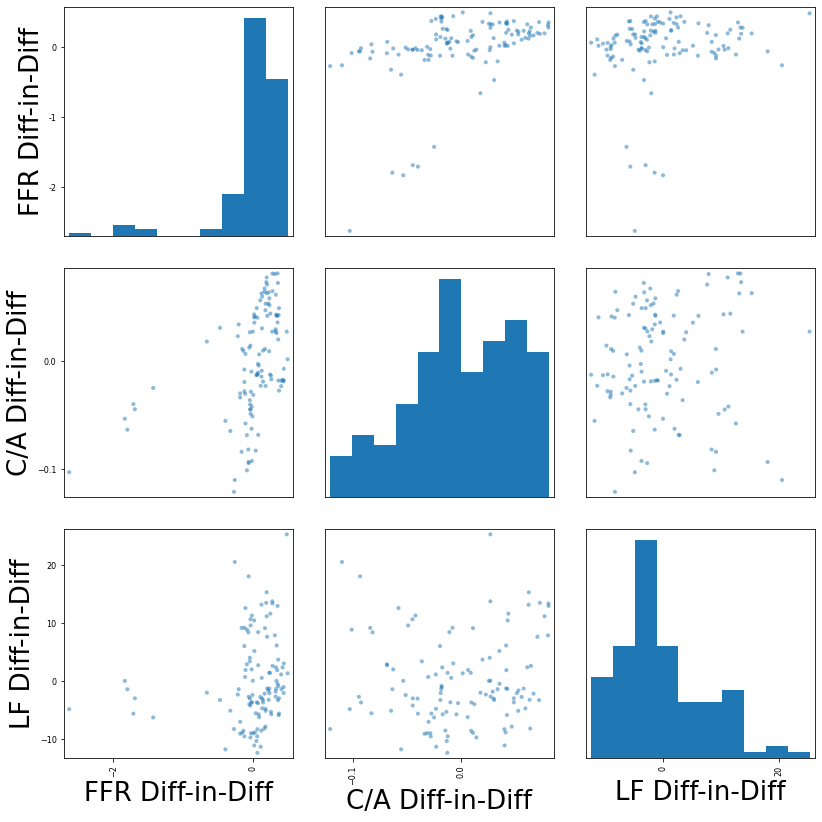

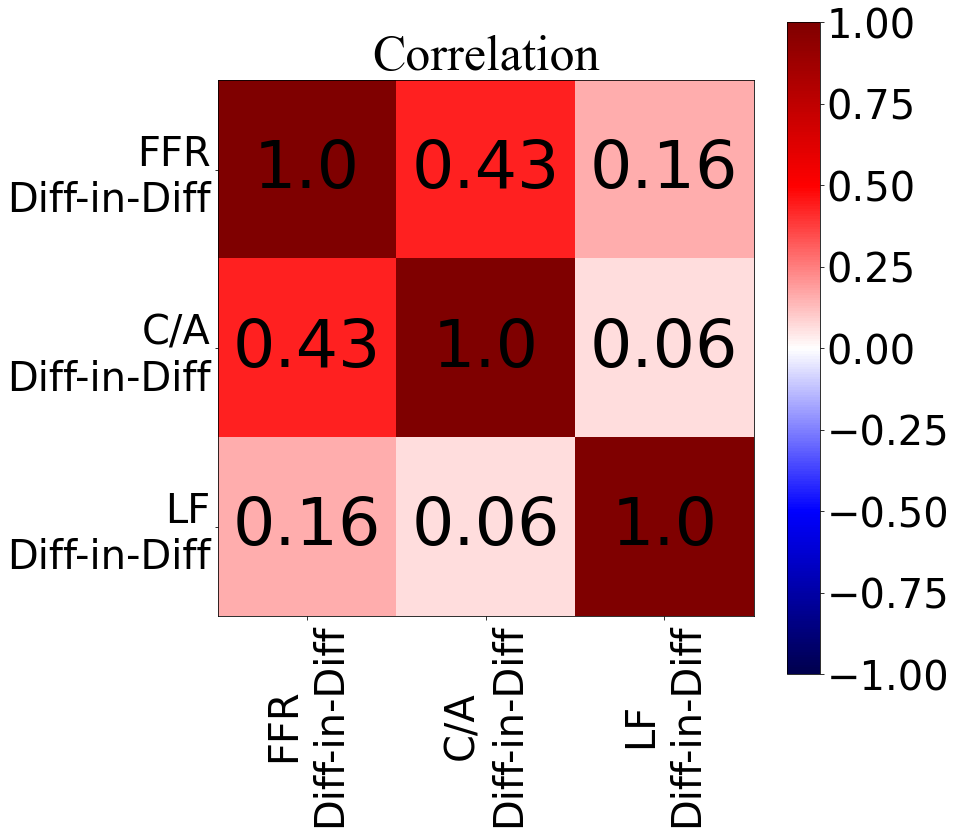

                  FFR Diff-in-Diff  C/A Diff-in-Diff  LF Diff-in-Diff
FFR Diff-in-Diff          0.000000         -0.000001        -0.086865
C/A Diff-in-Diff         -0.000001          0.000000        -0.493551
LF Diff-in-Diff          -0.086865         -0.493551         0.000000


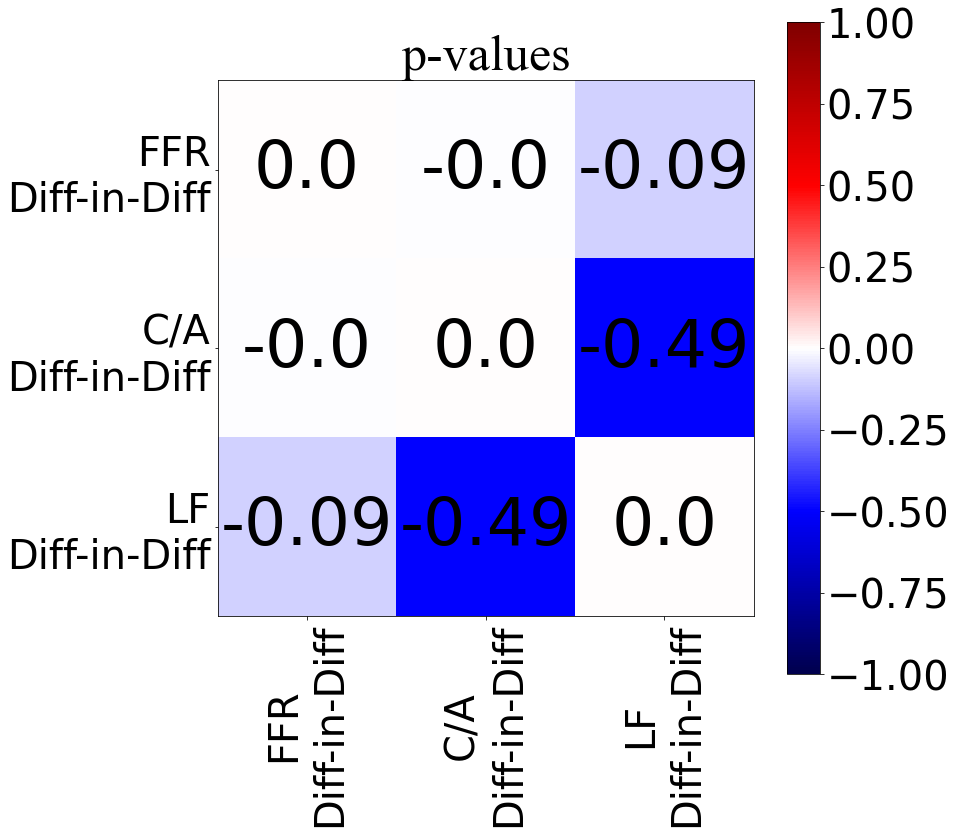

                                                   Effective Federal Funds Rate Diff-in-Diff (%)  \
Effective Federal Funds Rate Diff-in-Diff (%)                                                NaN   
Currency in Circulation / Total Assets Diff-in-...        [71.15922148039876, 5.066530055612936]   
Unemployment Loss Diff-in-Diff                           [40.970360549740185, 5.207371614845808]   
Inflation Loss Diff-in-Diff                             [16.332641223807975, 0.9001190742951841]   

                                                   Currency in Circulation / Total Assets Diff-in-Diff  \
Effective Federal Funds Rate Diff-in-Diff (%)                  [71.15922148039871, 5.066530055612936]    
Currency in Circulation / Total Assets Diff-in-...                                                NaN    
Unemployment Loss Diff-in-Diff                                [58.78872101251226, 11.479643307471422]    
Inflation Loss Diff-in-Diff                                      [37.489699

<ipython-input-33-dffa8ba66cfa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Constant"] = 1
<ipython-input-33-dffa8ba66cfa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Constant"] = 1
<ipython-input-33-dffa8ba66cfa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

                            OLS Regression Results                            
Dep. Variable:     $\pi$ Diff-in-Diff   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     84.00
Date:                Thu, 23 Sep 2021   Prob (F-statistic):           8.26e-33
Time:                        20:15:16   Log-Likelihood:                -60.420
No. Observations:                 117   AIC:                             130.8
Df Residuals:                     112   BIC:                             144.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
FFR Diff-in-Diff Lag       0

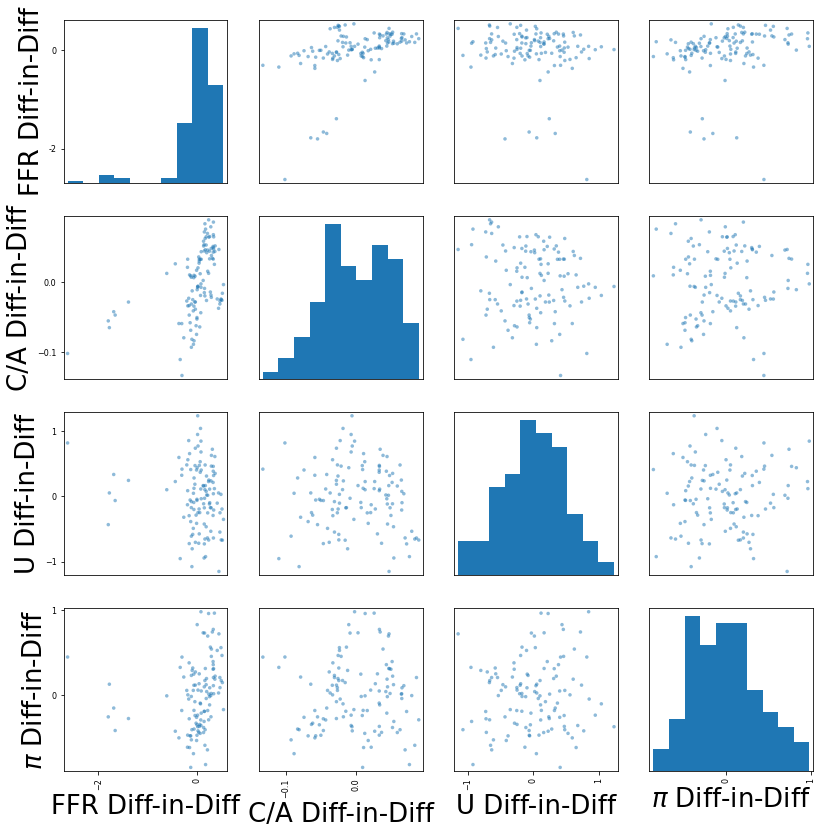

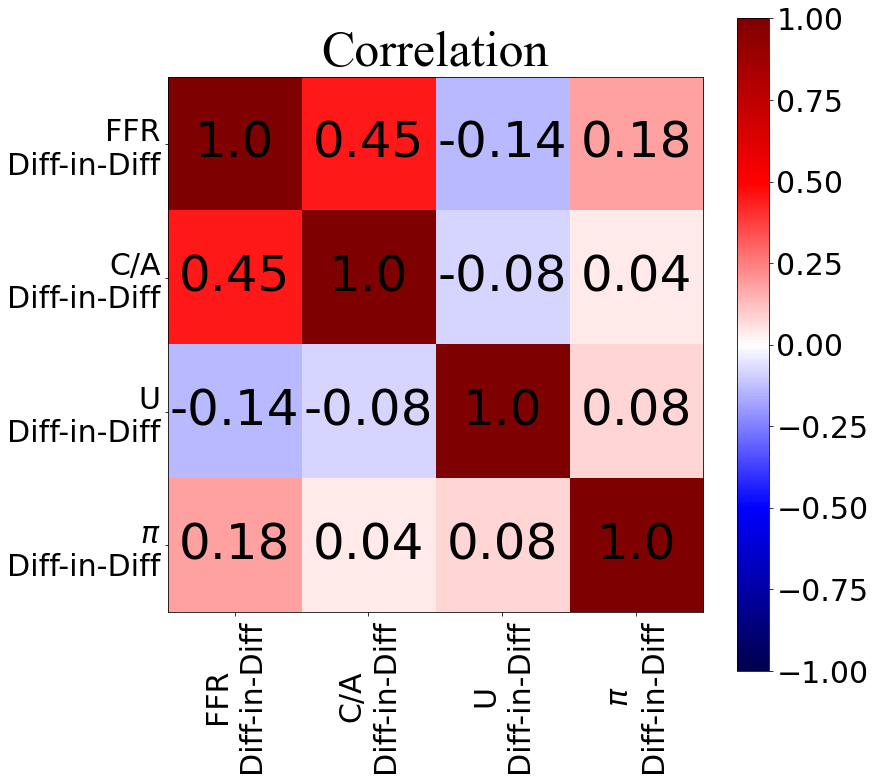

                    FFR Diff-in-Diff  C/A Diff-in-Diff  U Diff-in-Diff  \
FFR Diff-in-Diff        0.000000e+00     -3.444435e-07       -0.137234   
C/A Diff-in-Diff       -3.444435e-07      0.000000e+00       -0.397776   
U Diff-in-Diff         -1.372342e-01     -3.977765e-01        0.000000   
$\pi$ Diff-in-Diff     -4.850054e-02     -6.713539e-01       -0.390582   

                    $\pi$ Diff-in-Diff  
FFR Diff-in-Diff             -0.048501  
C/A Diff-in-Diff             -0.671354  
U Diff-in-Diff               -0.390582  
$\pi$ Diff-in-Diff            0.000000  


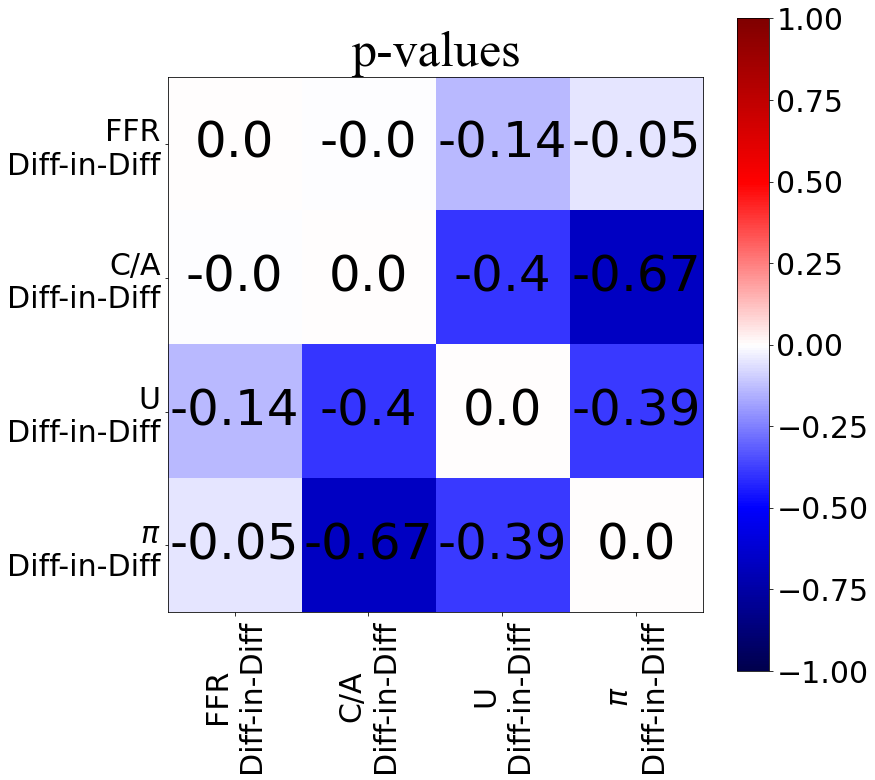

                    Aggregated  Decomposed
FFR Diff-in-Diff      0.239370    0.235628
C/A Diff-in-Diff      0.607603    0.616222
LF Diff-in-Diff       0.794669         NaN
U Diff-in-Diff             NaN    0.751532
$\pi$ Diff-in-Diff         NaN    0.741083


In [33]:

pp = PdfPages("OLSResiduals.pdf")

# diffs = ["", " Diff"]
diffs = ["", " Diff", " Diff-in-Diff"]

reg_dict = {}
for diff in diffs:
    plot_vars_dct = {"Aggregated": ["Effective Federal Funds Rate" +diff + " (%)",
                         "Currency in Circulation / Total Assets" + diff,
                        "Loss Function" + diff],
#                      1:["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Loss Function" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
                     "Decomposed":["Effective Federal Funds Rate" +diff + " (%)",
                        "Currency in Circulation / Total Assets" + diff,
                         "Unemployment Loss" + diff,
                        "Inflation Loss" + diff],

#                      3:["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Unemployment Loss Sq" + diff,
#                         "Inflation Loss Sq" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
                    }
    reg_dict[diff] = {}
    coint_dict = {}
    for i in plot_vars_dct:
        
        
        reg_dict[diff][i]={}
        residuals = {}
        var_data = data[plot_vars_dct[i]].dropna().loc["2009-07-31":"2020-03-31"]#.resample("Q").last()
        print(cointegration_df(var_data))
        print(adfuller_df(var_data))
        
        min_keys = list(var_data.keys())
        keys = list(var_data.keys())
        for key in var_data:
#             for i in range(1, year + 1):
            new_key = key +" Lag"# + str(i)
            var_data[new_key] = var_data[key].shift(year)
        var_data = var_data.dropna()
        for key in var_data:
            for rename_key in rename_dct:
                if rename_key in key:
                    dif = diff if "Diff" in key else""
                    lag = " Lag" if "Lag" in key else ""
                    var_data.rename(columns={key:rename_dct[rename_key]+dif + lag}, inplace = True)
        keys = [key for key in var_data if "Lag" not in key]
        for key in keys:
            Y = var_data[[key]]
            X_vars = [k for k in var_data if "Lag" in k and "predict" not in k]
#             X_vars = [k for k in var_data if key != k and "predict" not in k and "Lag" not in k]
#             keys.remove(key)
            X = var_data[X_vars]
            X["Constant"] = 1
            model = sm.OLS(Y,X)
            results = model.fit()
            print(results.summary())
            predict = results.predict()
            var_data[key + " predict"] = predict
            residuals[key] = results.resid
#             diff = " Diff" if "Diff" in key else""
            reg_dict[diff][i][key] = results.rsquared_adj
        residuals = pd.DataFrame(residuals)    
        res_corr = residuals[keys].corr()
        pval_corr = residuals[keys].corr(method=lambda x, y: pearsonr(x, y)[1]*-1) - np.eye(*res_corr.shape)
        
        formatted_scatter_matrix(residuals[keys], pp)
        corr_matrix_heatmap(res_corr, pp)
        print(pval_corr)
        corr_matrix_heatmap(pval_corr, pp, "p-values")
    print(pd.DataFrame(reg_dict[diff]))
pp.close()
#         pcs_full = {key:{} for key in keys}
#         pcs = {key:{} for key in keys}
#         p_vals = {key:{} for key in keys}
#         for key1 in keys:
#             for key2 in keys:
#                 if key1 == key2:
#                     pcs[key1][key2] = 1
#                 else:
#                     pcs_full[key1][key2] = var_data.partial_corr(x = key1, y = key2, covar = None,method = "pearson") 
#                     pcs[key1][key2] = pcs_full[key1][key2]["r"].values[0]
#                     p_vals[key1][key2] = pcs_full[key1][key2]["p-val"].values[0]
#         pcs_df = pd.DataFrame(pcs)
#         p_vals_df = pd.DataFrame(p_vals)
#         for key in min_keys:
#             lag_keys = [k for k in keys if key in k]
#             print(pcs_df.loc[lag_keys, lag_keys])




#             print(p_vals_df.loc[lag_keys, lag_keys])
            
#             print(pcs_df.loc[min_keys, min_keys])
#             print(p_vals_df.loc[min_keys, min_keys])

#         var_data = data[plot_vars_dct[i]].dropna().loc["2009-07-31":"2020-03-31"]#.resample("Q").last()
#         model = VAR(var_data)
#         results = model.fit(12)
#         results.summary()
#         irf = results.irf(24)
#         # irf.plot(orth=False)
#         for key in var_data.keys(): 
#             if "Funds" in key:
#                 irf.plot(impulse=key)
#                 plt.xlabel("Months")
#                 plt.show()
#                 plt.close()
#                 irf.plot_cum_effects(orth=False, impulse = key)
#                 plt.xlabel("Months")
#                 plt.show()
#                 plt.close()


In [20]:
X

,Effective Federal Funds Rate Diff (%),Currency in Circulation / Total Assets Diff,Unemployment Loss Diff,Constant
DATE,,,,
2009-08-31,-1.836129,-0.468871,3.5,1
2009-09-30,-1.665000,-0.395920,3.7,1
2009-10-31,-0.851290,-0.070351,3.5,1
2009-11-30,-0.268667,0.018627,3.1,1
2009-12-31,-0.037097,0.021549,2.6,1
...,...,...,...,...
2019-11-30,-0.644333,0.028965,-0.2,1
2019-12-31,-0.723226,0.017937,-0.3,1
2020-01-31,-0.849355,0.010401,-0.5,1


In [ ]:
for diff, val in reg_dict.items():
    print(pd.DataFrame(val))

In [ ]:
# undirected_graph = build_skeleton(df, undirected_graph)                                   
# undirected_graph

pp = PdfPages("LagOLSResiduals.pdf")

# diffs = ["", " Diff"]
diffs = ["", " Diff"]
reg_dict = {}
for diff in diffs:
    plot_vars_dct = {0: ["Effective Federal Funds Rate" +diff + " (%)",
                         "Currency in Circulation / Total Assets" + diff,
                        "Loss Function" + diff],
#                      1:["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Loss Function" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
                     2:["Effective Federal Funds Rate" +diff + " (%)",
                        "Currency in Circulation / Total Assets" + diff,
                         "Unemployment Loss" + diff,
                        "Inflation Loss" + diff],

#                      3:["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Unemployment Loss Sq" + diff,
#                         "Inflation Loss Sq" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
                    }
    reg_dict[diff] = {}
    for i in plot_vars_dct:
        reg_dict[diff][i] = {}
        residuals = {}
        var_data = data[plot_vars_dct[i]].dropna().loc["2009-07-31":"2020-03-31"]#.resample("Q").last()
        min_keys = list(var_data.keys())
        keys = list(var_data.keys())
        for key in var_data:
#             for i in range(1, year + 1):
            new_key = key +" Lag"# + str(i)
            var_data[new_key] = var_data[key].shift(year)
        var_data = var_data.dropna()
        for key in var_data:
            for rename_key in rename_dct:
                if rename_key in key:
                    diff = " Diff" if "Diff" in key else""
                    lag = " Lag" if "Lag" in key else ""
                    var_data.rename(columns={key:rename_dct[rename_key]+diff + lag}, inplace = True)
        keys = [key for key in var_data if "Lag" not in key]
        for key in keys:
            Y = var_data[[key]]
            X_vars = [k for k in var_data if "Lag" in k and "predict" not in k]
#             X_vars = [k for k in var_data if key != k and "predict" not in k and "Lag" not in k]
#             keys.remove(key)
            X = var_data[X_vars]# + [key + " Lag"]]
            X["Constant"] = 1
            model = sm.OLS(Y,X)
            results = model.fit()
            print(results.summary())
            predict = results.predict()
            var_data[key + " predict"] = predict
            residuals[key] = results.resid
            reg_dict[diff][i][key] = results.rsquared_adj
            
        residuals = pd.DataFrame(residuals)    
        res_corr = residuals[keys].corr()
        pval_corr = residuals[keys].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*res_corr.shape)
        
        formatted_scatter_matrix(residuals[keys], pp)
        corr_matrix_heatmap(res_corr, pp)
        corr_matrix_heatmap(pval_corr, pp, "p-values")

pp.close()
#         pcs_full = {key:{} for key in keys}
#         pcs = {key:{} for key in keys}
#         p_vals = {key:{} for key in keys}
#         for key1 in keys:
#             for key2 in keys:
#                 if key1 == key2:
#                     pcs[key1][key2] = 1
#                 else:
#                     pcs_full[key1][key2] = var_data.partial_corr(x = key1, y = key2, covar = None,method = "pearson") 
#                     pcs[key1][key2] = pcs_full[key1][key2]["r"].values[0]
#                     p_vals[key1][key2] = pcs_full[key1][key2]["p-val"].values[0]
#         pcs_df = pd.DataFrame(pcs)
#         p_vals_df = pd.DataFrame(p_vals)
#         for key in min_keys:
#             lag_keys = [k for k in keys if key in k]
#             print(pcs_df.loc[lag_keys, lag_keys])




#             print(p_vals_df.loc[lag_keys, lag_keys])
            
#             print(pcs_df.loc[min_keys, min_keys])
#             print(p_vals_df.loc[min_keys, min_keys])

#         var_data = data[plot_vars_dct[i]].dropna().loc["2009-07-31":"2020-03-31"]#.resample("Q").last()
#         model = VAR(var_data)
#         results = model.fit(12)
#         results.summary()
#         irf = results.irf(24)
#         # irf.plot(orth=False)
#         for key in var_data.keys(): 
#             if "Funds" in key:
#                 irf.plot(impulse=key)
#                 plt.xlabel("Months")
#                 plt.show()
#                 plt.close()
#                 irf.plot_cum_effects(orth=False, impulse = key)
#                 plt.xlabel("Months")
#                 plt.show()
#                 plt.close()


In [ ]:
for diff, val in reg_dict.items():
    print(pd.DataFrame(val))

In [ ]:
from statsmodels.tsa.api import VAR
plt.rcParams.update({"font.size":12})

diffs = ["", " Diff"]
pp = PdfPages("VARPlots.pdf")

for diff in diffs:
    plot_vars_dct = {0: ["Effective Federal Funds Rate" +diff + " (%)",
                         "Currency in Circulation / Total Assets" + diff,
                        "Loss Function" + diff],
#                      1:["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Loss Function" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
                     2:["Effective Federal Funds Rate" +diff + " (%)",
                        "Currency in Circulation / Total Assets" + diff,
                         "Unemployment Loss" + diff,
                        "Inflation Loss" + diff],

#                      3:["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Unemployment Loss Sq" + diff,
#                         "Inflation Loss Sq" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
                    }
    for i in plot_vars_dct:
        var_data = data[plot_vars_dct[i]].dropna().loc["2009-07-31":"2020-02-29"]#.resample("Q").last()
        for key in var_data:
            for rename_key in rename_dct:
                if rename_key in key:
                    var_data.rename(columns={key:rename_dct[rename_key]}, inplace = True)
        model = VAR(var_data)
#         model.select_order(12)
#         results = model.fit(maxlags=24, ic='aic')
        results = model.fit(12)
        formatted_scatter_matrix(results.resid, pp)
        corr_matrix_heatmap(results.resid.corr(), pp)
        print(results.summary())
        
#         print(results.test_causality("Effective Federal Funds Rate" +diff + " (%)", ['realinv', 'realcons'], kind='f')
#         fig = results.plot_acorr(24)        
#         pp.savefig(fig)
        irf = results.irf(24)        
        fig = irf.plot(orth=False, figsize = (20,12))
        pp.savefig(fig)
        fig = irf.plot_cum_effects(orth=False, figsize = (20,12))
        pp.savefig(fig)
        #         irf.plot_cum_effects(orth = False)
#         for key in var_data.keys():
#             irf.plot(orth = False, impulse=key)
#             irf.plot_cum_effects(orth=False, impulse = key)
pp.close()       


In [ ]:
results.resid.corr()

In [ ]:
diffs = [" Diff"]
for diff in diffs:
    plot_vars_dct = {0: ["Linear Loss" + diff,
                         "Effective Federal Funds Rate" +diff + " (%)",
                         "Currency in Circulation / Total Assets" + diff],
#                      1:["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Linear Loss" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
                     2:["Unemployment Loss" + diff,
                        "Inflation Loss" + diff,
                        "Effective Federal Funds Rate" +diff + " (%)",
                        "Currency in Circulation / Total Assets" + diff],
#                      3:["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Unemployment Loss" + diff,
#                         "Inflation Loss" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
    }
    for key, val in plot_vars_dct.items():
        fig, ax = plt.subplots(figsize = (12, 8))
        axes= {}
        i = 0
        for key in val:
            axes[key] = ax.twinx() if i > 0 else ax
            a = axes[key]
            a.set_yticks([])
            data.loc["2009-07-31":][key].plot.line(ax = a, 
                                  c = "C" + str(i),
                                 legend = False)

            i += 1
        plt.legend()
#         for x in val:
#             for y in val:
#                 if x != y:
#                     for z in val:
#                         if x != z and y != z:
#                             fig, ax = plt.subplots(figsize = (12, 8))
#                             data.loc["2008-10-31":].plot.scatter(x = x, y = y, c = z, 
#                                               cmap= "viridis",ax = ax)
#                             plt.show()
#                             plt.close()


In [ ]:
from pgmpy.estimators import PC
from pgmpy.base import DAG

keys = dag_df.keys()
c = PC(dag_df.dropna())
max_cond_vars = len(keys) - 2

sig = 0.05
variant = "parallel"
ci_test = "pearsonr"
model = c.estimate(return_type = "dag",variant= variant, 
                   significance_level = sig, 
                   max_cond_vars = max_cond_vars, ci_test = ci_test)

edges = model.edges()
pcorr = dag_df.pcorr()
weights = {}
for edge in edges:
    print(edge, ":",pcorr[edge[0]].loc[edge[1]])
skel, sep_sets = c.build_skeleton(variant = variant, ci_test = ci_test, significance_level = 0.01, 
                   max_cond_vars = max_cond_vars)
sep_sets

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import networkx as nx
plt.rcParams.update({"font.size":20})

def graph_DAG(edges, df, title = ""):
    pcorr = df.pcorr()
    graph = nx.DiGraph()
    edge_labels = {}
    for edge in edges:
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
        
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,20))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     #font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)

graph_DAG(edges, dag_df)

In [ ]:
from pgmpy.estimators import PC
from pgmpy.base import DAG

keys = dag_df.keys()
c = PC(dag_df.dropna())
max_cond_vars = len(keys) - 2

variant = "parallel"
ci_test = "pearsonr"
model = c.estimate(return_type = "dag",variant= variant, 
                   significance_level = sig, 
                   max_cond_vars = max_cond_vars, ci_test = ci_test)

edges = model.edges()
pcorr = dag_df.pcorr()
weights = {}
for edge in edges:
    print(edge, ":",pcorr[edge[0]].loc[edge[1]])
skel, sep_sets = c.build_skeleton(variant = variant, ci_test = ci_test, significance_level = 0.01, 
                   max_cond_vars = max_cond_vars)
sep_sets

In [ ]:
graph_DAG(edges, dag_df)

In [ ]:
from pgmpy.estimators import PC
from pgmpy.base import DAG

keys = dag_df.keys()
c = PC(dag_df.dropna())
max_cond_vars = len(keys) - 2

variant = "parallel"
ci_test = "pearsonr"
model = c.estimate(return_type = "dag",variant= variant, 
                   significance_level = sig, 
                   max_cond_vars = max_cond_vars, ci_test = ci_test)

edges = model.edges()
pcorr = dag_df.pcorr()
weights = {}
for edge in edges:
    print(edge, ":",pcorr[edge[0]].loc[edge[1]])
skel, sep_sets = c.build_skeleton(variant = variant, ci_test = ci_test, significance_level = 0.01, 
                   max_cond_vars = max_cond_vars)
sep_sets

In [ ]:
graph_DAG(edges, dag_df)

In [ ]:
from pgmpy.estimators import PC
from pgmpy.base import DAG

keys = dag_df.keys()
c = PC(dag_df.dropna())
max_cond_vars = len(keys) - 2

variant = "parallel"
ci_test = "pearsonr"
model = c.estimate(return_type = "dag",variant= variant, 
                   significance_level = sig, 
                   max_cond_vars = max_cond_vars, ci_test = ci_test)

edges = model.edges()
pcorr = dag_df.pcorr()
weights = {}
for edge in edges:
    print(edge, ":",pcorr[edge[0]].loc[edge[1]])
skel, sep_sets = c.build_skeleton(variant = variant, ci_test = ci_test, significance_level = 0.01, 
                   max_cond_vars = max_cond_vars)
sep_sets

In [ ]:
for key in sep_sets:
    print(list(sep_sets[key]))

In [ ]:
graph_DAG(edges, dag_df)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import networkx as nx
plt.rcParams.update({"font.size":20})

def graph_DAG(edges, df,sep_sets, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    pcorr = df.pcorr()
    for edge in sep_sets:
        sep_set = list(sep_sets[edge])
        key = list(edge)
#        pcorr = df[key + sep_set].pcorr()
        edge_labels[edge] = str(round(pcorr[key[0]].loc[key[1]],2))
    print(edge_labels)
    graph.add_edges_from(sep_sets.keys())
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,20))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     #font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)

graph_DAG(edges, dag_df, sep_sets)

In [ ]:
dag_df

In [ ]:
figsize = (20,12)
fig,ax = plt.subplots(figsize = figsize)

ax2 = ax.twinx()
ax3 = ax.twinx()
data[["Currency in Circulation / Total Assets"]].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax)
data[["Effective Federal Funds Rate (%)"]].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax2,
                                                        c = "C1")
data[["Linear Loss"]].iloc[:-1].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .1,
                                                      ax = ax3,
                                                        c = "k")

ax.set_yticklabels([str(int(val * 100)) + "%" for val in ax.get_yticks()], c = "C0")
ax2.set_yticklabels([str(int(val)) + "%" for val in ax2.get_yticks()], c = "C1")
ax3.set_yticklabels(ax3.get_yticks(), alpha = .2, c = "k")
ax3.set_yticks([])

ax3.axhline(0, c = "k", alpha = .1, linewidth = 5, ls = "--")

plt.axvline(datetime.datetime(2008,10,1), c = "k", ls = "--", alpha = .9)
ax.text(datetime.datetime(2013,3,1), .42, "Currency in Circulation\n/  \nTotal Assets", fontsize = 25, c = "C0", 
        ha = "center")
ax.text(datetime.datetime(2018,5,1), .58, "Effective\nFederal\nFunds\nRate", fontsize = 25, c = "C1", 
        ha = "center")
ax.text(datetime.datetime(2014,6,1), .78, "Linear\nLoss\nFunction", fontsize = 25, c = "k", alpha = .3, 
        ha = "center")
ax.text(datetime.datetime(2002,10,1), .955, "0", fontsize = 30, c = "k", alpha = .3, 
        ha = "right")
ax.text(datetime.datetime(2022,1,1), .955, "0 ", fontsize = 30, c = "k", alpha = .3, 
        ha = "right")

In [ ]:
fig, ax = plt.subplots(figsize = (30,15))
data[["Linear Loss Diff", "Total Assets Growth Rate (%)"]].plot.scatter(x = "Linear Loss Diff", y = "Total Assets Growth Rate (%)", ax = ax)
plt.xticks(rotation=90)


In [ ]:
fig, ax = plt.subplots(figsize = (30,15))
data.iloc[:-1].plot.scatter(x = "Linear Loss", y = "Currency in Circulation / Total Assets", ax = ax)
plt.xticks(rotation=90)
